## Week 4, Lab 1: Predicting Left-Handedness from Psychological Factors
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

We'll walk through a full data science problem in this lab. 

---
## Step 1: Define The Problem.

You're currently a data scientist working at a university. A professor of psychology is attempting to study the relationship between personalities and left-handedness. They have tasked you with gathering evidence so that they may publish.

Specifically, the professor says "I need to prove that left-handedness is caused by some personality trait. Go find that personality trait and the data to back it up."

As a data scientist, you know that any real data science problem must be **specific** and **conclusively answerable**. For example:
- Bad data science problem: "What is the link between obesity and blood pressure?"
    - This is vague and is not conclusively answerable. That is, two people might look at the conclusion and one may say "Sure, the problem has been answered!" and the other may say "The problem has not yet been answered."
- Good data science problem: "Does an association exist between obesity and blood pressure?"
    - This is more specific and is conclusively answerable. The problem specifically is asking for a "Yes" or "No" answer. Based on that, two independent people should both be able to say either "Yes, the problem has been answered" or "No, the problem has not yet been answered."
- Excellent data science problem: "As obesity increases, how does blood pressure change?"
    - This is very specific and is conclusively answerable. The problem specifically seeks to understand the effect of one variable on the other.

### 1. In the context of the left-handedness and personality example, what are three specific and conclusively answerable problems that you could answer using data science? 

> You might find it helpful to check out the codebook in the repo for some inspiration.

Answer:

1.  As one's response to Q1 increases, are people more or less likely to be left-handed?
2.  Does the distribution of handedness vary based on one's response to Q1?
3.  Which question (Q1-Q44) has the highest correlation with handedness?

---
## Step 2: Obtain the data.

### 2. Read in the file titled "data.csv."
> Hint: Despite being saved as a .csv file, you won't be able to simply `pd.read_csv()` this data!

In [1]:
# import required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, RocCurveDisplay, roc_auc_score, recall_score, precision_score, f1_score, classification_report

from scipy.stats import pearsonr

from yellowbrick.classifier import PrecisionRecallCurve

from imblearn.over_sampling import RandomOverSampler

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
# Read in data
df = pd.read_csv('data.csv', sep='\t')
df_copy = df.copy()

In [3]:
# Print the first 5 rows
df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,country,fromgoogle,engnat,age,education,gender,orientation,race,religion,hand
0,4,1,5,1,5,1,5,1,4,1,...,US,2,1,22,3,1,1,3,2,3
1,1,5,1,4,2,5,5,4,1,5,...,CA,2,1,14,1,2,2,6,1,1
2,1,2,1,1,5,4,3,2,1,4,...,NL,2,2,30,4,1,1,1,1,2
3,1,4,1,5,1,4,5,4,3,5,...,US,2,1,18,2,2,5,3,2,2
4,5,1,5,1,5,1,5,1,3,1,...,US,2,1,22,3,1,1,3,2,3


### 3. Ethics Considerations
Suppose that, instead of us giving you this data in a file, you were actually conducting a survey to gather this data yourself. From an ethics/privacy point of view, what are three things you might consider when attempting to gather this data?
> When working with sensitive data like sexual orientation or gender identity, we need to consider how this data could be used if it fell into the wrong hands!

Answer:

1. We should question whether or not we need to gather the sexual orientation/gender identity data. If this is necessary for what we want to study, then we need to be smart about how we include it. If this is not necessary, then we should not be gathering this data!

2. We should collect this data anonymously, and NOT just confidentially.
    - Anonymously means that we do not collect personally identifiable information (PII).
    - Confidentially means we collect PII but we don't make that available to others.
    - If we have access to names or IC numbers, that exists the possibility that someone could hack us and connect names/ICs with gender, orientation, etc. Instead, we should collect the data without names or PII so that even if our data are hacked, then it will be much harder to connect responses with an individual.

3. From the perspective of inclusivity, we want to make sure our responses fit everyone trying to respond (after all this is how the world has become...). For example, for the gender category, we should at minimum have a male, female, and other category. However, we might consider including options for transgender individuals, having only a fill-in-the-blank response instead of explicit choices, and/or having "prefer to not answer" category.

4. (EXTRA) For a particularly advanced option, there's an area of study called differential privacy that allows us to study population-level effects without exposing any individual. We can ask a person to answer the question, 'Do you own the attribute A' and do the following:
    - Have each respondent toss a coin.
    - If heads, then toss the coin (ignoring the outcome) and answer the question honestly.
    - If tails, then toss the coin again and answer "Yes" if heads, "No" if tails.
        - The seemingly redundant extra toss in the first case is needed in situations where just the act of tossing a coin may be observed by others, even if the actual result stays hidden.
        - If p is the true proportion of people with A, then we expect to obtain (1/4)(1-p) + (3/4)p = (1/4) + p/2 positive responses. Hence it is possible to estimate p.
        - In particular, if the attribute A is synonymous with illegal behavior, then answering "Yes" is not incriminating, insofar as the person has a probability of a "Yes" response, whatever it may be.
        - So using transgenderism as an example, an individual who answers "transgender" may or may not actually be transgender. Someone who hacks the data would never be able to know who truly identifies as transgender versus who identifies as transgender based on the coin flip. However, because we know approximately how many coin flips should be heads versus tails, we can estimate the percentage of individuals who are transgender. This allows us to study what we want to study but also allows us to maintain privacy for individuals!

---
## Step 3: Explore the data.

### 4. Conduct exploratory data analysis on this dataset.
> If you haven't already, be sure to check out the codebook in the repo, as that will help in your EDA process.
> Inspect the data and be convinced there is no issue with the data

In [4]:
# Check column names
df.columns

Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q31',
       'Q32', 'Q33', 'Q34', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40', 'Q41',
       'Q42', 'Q43', 'Q44', 'introelapse', 'testelapse', 'country',
       'fromgoogle', 'engnat', 'age', 'education', 'gender', 'orientation',
       'race', 'religion', 'hand'],
      dtype='object')

In [5]:
# Check data types
df.dtypes

Q1              int64
Q2              int64
Q3              int64
Q4              int64
Q5              int64
Q6              int64
Q7              int64
Q8              int64
Q9              int64
Q10             int64
Q11             int64
Q12             int64
Q13             int64
Q14             int64
Q15             int64
Q16             int64
Q17             int64
Q18             int64
Q19             int64
Q20             int64
Q21             int64
Q22             int64
Q23             int64
Q24             int64
Q25             int64
Q26             int64
Q27             int64
Q28             int64
Q29             int64
Q30             int64
Q31             int64
Q32             int64
Q33             int64
Q34             int64
Q35             int64
Q36             int64
Q37             int64
Q38             int64
Q39             int64
Q40             int64
Q41             int64
Q42             int64
Q43             int64
Q44             int64
introelapse     int64
testelapse

In [6]:
# Check for missing values
df.isnull().sum().sum()

0

In [7]:
# Check for duplicates
df.duplicated().sum()

0

In [8]:
# Check shape
df.shape

(4184, 56)

In [9]:
# Summary statistics... seems like some respondents are answering the 44 questions with a value of '0'
df.describe()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,testelapse,fromgoogle,engnat,age,education,gender,orientation,race,religion,hand
count,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,...,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000
mean,1.962715,3.829589,2.846558,3.186902,2.865440,3.672084,3.216539,3.184512,2.761233,3.522945,...,479.994503,1.576243,1.239962,30.370698,2.317878,1.654398,1.833413,5.013623,2.394359,1.190966
std,1.360291,1.551683,1.664804,1.476879,1.545798,1.342238,1.490733,1.387382,1.511805,1.242890,...,3142.178542,0.494212,0.440882,367.201726,0.874264,0.640915,1.303454,1.970996,2.184164,0.495357
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.000000,1.000000,0.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,1.000000,2.000000,1.000000,3.000000,2.000000,2.000000,1.000000,3.000000,...,186.000000,1.000000,1.000000,18.000000,2.000000,1.000000,1.000000,5.000000,1.000000,1.000000
50%,1.000000,5.000000,3.000000,3.000000,3.000000,4.000000,3.000000,3.000000,3.000000,4.000000,...,242.000000,2.000000,1.000000,21.000000,2.000000,2.000000,1.000000,6.000000,2.000000,1.000000
75%,3.000000,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,4.000000,5.000000,...,324.250000,2.000000,1.000000,27.000000,3.000000,2.000000,2.000000,6.000000,2.000000,1.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,119834.000000,2.000000,2.000000,23763.000000,4.000000,3.000000,5.000000,7.000000,7.000000,3.000000


In [10]:
# Create a list of column names
col_list = list(df.columns)
# Create a list of unique values for each column
answer_vals = [list(df[col].unique()) for col in col_list]
# Combine both column names and unique values as key: value pair in a dictionary
new_dict = dict(zip(col_list, answer_vals))

In [11]:
# uncomment to print out as the output is quite long
# new_dict

In [12]:
# Print value counts for education, gender, orientation and race
print(df['education'].value_counts(), '\n')
print(df['gender'].value_counts(), '\n')
print(df['orientation'].value_counts(), '\n')
print(df['race'].value_counts(), '\n')

education
2    2055
3    1086
1     546
4     446
0      51
Name: count, dtype: int64 

gender
2    2212
1    1586
3     304
0      82
Name: count, dtype: int64 

orientation
1    2307
2     833
5     349
3     335
4     237
0     123
Name: count, dtype: int64 

race
6    2793
1     393
2     383
7     342
3     168
0      66
4      33
5       6
Name: count, dtype: int64 



#### Note

There seem to be incorrect responses (a value of 0) in almost every column. Let's remove any row with an incorrect response and see how much data we have left.


In [13]:
# Drop every row with an incorrect response
for col in col_list:
    df = df[df[col] != 0]

In [14]:
# Check shape again
df.shape

(3481, 56)

#### Note

Dropping any row with an incorrect response leaves us with 3481 rows from 4184 rows or about 83% of the original data. This doesn't seem to be quite ideal as even the wrong responses contain some sort of signal regarding left-handedness. Perhaps, people who answer surveys incorrectly would be more likely to be left-handed?

In [15]:
# Assign df_copy to df to undo the change above
df = df_copy

In [16]:
# Check unique value of age.. seems like there are some improbable ages
df['age'].unique()

array([   22,    14,    30,    18,    59,    15,    16,    13,    17,
          21,    55,    25,    27,    20,    23,    49,    29,    32,
          19,    37,    26,    56,    39,    33,    64,    52,    48,
          42,    31,    44,    54,    38,    43,    28,    62,    40,
          34,    24,    45,    53,    35,    57,    47,    58,    41,
          61,    46,    63,    65,    76,    50,    69,    36,    51,
          60,    68,    67,    73,    70,    86,    78,   123,   409,
       23763,    77,    85], dtype=int64)

In [17]:
# For non-errorneous ages, find the mean of age
mean_age = np.mean(df[(df['age'] <= 123)]['age'])
mean_age

24.60521281683405

In [18]:
# Set the value of errorneous ages to mean_age
df.loc[(df['age'] >= 123), ['age']] = mean_age

In [19]:
# Check value counts for hand
df['hand'].value_counts()

hand
1    3542
2     452
3     179
0      11
Name: count, dtype: int64

In [20]:
# Drop rows with value of 0 for hand
df = df[df['hand'] != 0]
# Drop rows with value of 3 for hand
df = df[df['hand'] != 3]

#### Note

I have dropped the errorneous values for hand (those that input '0') as there are only 11 such values. Also I have dropped the value of '3' for hand since those represent people who identify as ambidextrous and that would make this a multi-class classification problem. For the sake of simplicity, I have decided to approach the problem as a binary classification problem.

In [21]:
# Reassign the values of left-handedness to 1 and right-handedness to 0
df['hand'] = df['hand'].map({2: 1, 1: 0})

In [22]:
# Check value counts for hand again
df['hand'].value_counts()

hand
0    3542
1     452
Name: count, dtype: int64

---
## Step 4: Model the data.

### 5. Suppose I wanted to use Q1 - Q44 to predict whether or not the person is left-handed. Would this be a classification or regression problem? Why?

Answer: 

This would be a classification problem because we are trying to determine someone's class (left or right-handedness). The dependent variable, whether or not someone is left-handed, is categorical and unordered.

### 6. Why would we standardize our variables?
We want to use $k$-nearest neighbors to predict whether or not a person is left-handed based on their responses to Q1 - Q44. Before doing that, however, you remember that it is often a good idea to standardize your variables. 

In general, why would we standardize our variables? Give an example of when we would standardize our variables.

Answer: 

We would standardize our variables to be certain that they are being weighed on a similar scale. This is to ensure a certain feature, or variable, does not have undue influence on a model solely based on the scale in which it is measured.

In the context of K-nearest neighbors, it's especially important to standardize our variables. If we're trying to see which observations are "close" to one another and we have two variables that are on very different scales, then one variable will make observations look close to one another by virtue of their difference in magnitude. For example, observations will look close based on GPA but far away based on square footage. Standardization is especially important for distance-based classifiers.

### 7. Give an example of when we might not standardize our variables.

Answer: 

If our variables are already on the same scale, it doesn't make sense to standardize them. If we want to interpret our variables on their original scale, then sklearn StandardScaler has an inverse_transform method to scale the data back to their original representation.



### 8. Based on your answers to 6 and 7, do you think we should standardize our predictor variables in this case? Why or why not?

Answer: 

If we're only using Q1-Q44 as predictors, I would not standardize our predictor variables. They're already on the same scale (1 to 5) with the numbers representing the same things for each variable.


### 9. We want to use $k$-nearest neighbors to predict whether or not a person is left-handed. What munging/cleaning do we need to do to our $y$ variable in order to explicitly answer this question? Do it.

> If you have yet inspect the column 'hand', you should do it here.
> If you have addressed the issues the the data column 'hand', you may skip this portion, and answer - you have done ensuring the column has no issue.

Answer: 

I have already cleaned the data in an earlier step.

### 10. The professor for whom you work suggests that you set $k = 4$. In this specific case, why might this be a bad idea?

Answer: 

In this case, K controls the size of the neighborhood used to model the local statistical properties. A very small value for K makes the model more sensitive to local anomalies and exceptions, giving too many weight to these particular points, which will produce an overfitted model. On the contrary, a too large value of K would make the model ignore the local structure of the distribution it is trying to learn, and produce an underfitted model.

Furthermore, since the professor is recommending an even number of neighbours, this creates the possibility of ties, where the result will depend on the ordering of the training data. More precisely, the choice will be the class that appears first in the set of neighbours. Therefore, it will be better to choose an odd number of neighbours to avoid this problem.

### 11. Let's *(finally)* use $k$-nearest neighbors to predict whether or not a person is left-handed!

> Be sure to create a train/test split with your data!

> Create four separate models, one with $k = 3$, one with $k = 5$, one with $k = 15$, and one with $k = 25$.

> Instantiate and fit your models.

In [23]:
# Create a list containing the names of the first 44 columns (the personality questions)
features = col_list[0:44]
# Create our feature matrix
X = df[features]
# Create our target matrix
y = df['hand']
# Check for class imbalance
y.value_counts(normalize=True)

hand
0    0.88683
1    0.11317
Name: proportion, dtype: float64

In [24]:
# Create our train test split, stratify our splits
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123, stratify = y)

#### K = 3

In [25]:
# Instantiate our knn model
knn = KNeighborsClassifier(n_neighbors=3)

In [26]:
# Cross validate our model with 10 folds
val_score = cross_val_score(knn, X_train, y_train, cv = 10).mean()
print(f'The cross validated score is {val_score}')

The cross validated score is 0.8470680044593089


In [27]:
# Fit our knn model on the training data
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [28]:
# Score our model on the training data
train_score = knn.score(X_train, y_train)
print(f'The train score is {train_score}')

The train score is 0.8978297161936561


In [29]:
# Score our model on the test data
test_score = knn.score(X_test, y_test)
print(f'The test score is {test_score}')

The test score is 0.8568568568568569


#### K = 5

In [30]:
# Instantiate our knn model
knn = KNeighborsClassifier(n_neighbors=5)

In [31]:
# Cross validate our model with 10 folds
val_score = cross_val_score(knn, X_train, y_train, cv = 10).mean()
print(f'The cross validated score is {val_score}')

The cross validated score is 0.8714503901895206


In [32]:
# Fit our knn model on the training data
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [33]:
# Score our model on the training data
train_score = knn.score(X_train, y_train)
print(f'The train score is {train_score}')

The train score is 0.891151919866444


In [34]:
# Score our model on the test data
test_score = knn.score(X_test, y_test)
print(f'The test score is {test_score}')

The test score is 0.8768768768768769


#### K = 15

In [35]:
# Instantiate our knn model
knn = KNeighborsClassifier(n_neighbors=15)

In [36]:
# Cross validate our model with 10 folds
val_score = cross_val_score(knn, X_train, y_train, cv = 10).mean()
print(f'The cross validated score is {val_score}')

The cross validated score is 0.8868115942028986


In [37]:
# Fit our knn model on the training data
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

In [38]:
# Score our model on the training data
train_score = knn.score(X_train, y_train)
print(f'The train score is {train_score}')

The train score is 0.8868113522537563


In [39]:
# Score our model on the test data
test_score = knn.score(X_test, y_test)
print(f'The test score is {test_score}')

The test score is 0.8868868868868869


#### K = 25

In [40]:
# Instantiate our knn model
knn = KNeighborsClassifier(n_neighbors=25)

In [41]:
# Cross validate our model with 10 folds
val_score = cross_val_score(knn, X_train, y_train, cv = 10).mean()
print(f'The cross validated score is {val_score}')

The cross validated score is 0.8868115942028986


In [42]:
# Fit our knn model on the training data
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=25)

In [43]:
# Score our model on the training data
train_score = knn.score(X_train, y_train)
print(f'The train score is {train_score}')

The train score is 0.8868113522537563


In [44]:
# Score our model on the test data
test_score = knn.score(X_test, y_test)
print(f'The test score is {test_score}')

The test score is 0.8868868868868869


Being good data scientists, we know that we might not run just one type of model. We might run many different models and see which is best.

### 12. We want to use logistic regression to predict whether or not a person is left-handed. Before we do that, let's check the [documentation for logistic regression in sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Is there default regularization? If so, what is it? If not, how do you know?

Answer: 

Yes, there is default regularization - it is Ridge regularization.

- penalty = 'l2' indicates the L2 or Ridge penalty.
- C = 1.0 indicates that the inverse of our regularization strength is set at a default value of 1. Therefore a C of 0.1 will give an alpha of 10.

### 13. We want to use logistic regression to predict whether or not a person is left-handed. Before we do that, should we standardize our features?

Answer:

In general, we should standardize, because sklearn will regularize by default and we would not want the regularization penalty to unfairly penalise coefficients just because of the scale they were measured with. Though in this case, since my features are already on the same scale, then standardizing is not required.

An example of when I would standardize in logistic regression is if the variables/features were measured on different scales.
An example of when I would not standardize in logistic regression is if the variables/features were measured on the same scale.

### 14. Let's use logistic regression to predict whether or not the person is left-handed.


> Be sure to use the same train/test split with your data as with your $k$-NN model above!

> Create four separate models, one with LASSO and $\alpha = 1$, one with LASSO and $\alpha = 10$, one with Ridge and $\alpha = 1$, and one with Ridge and $\alpha = 10$. *(Hint: Be careful with how you specify $\alpha$ in your model!)*

> Instantiate and fit your models.

#### LASSO regularization

In [45]:
# Instantiate our logistic regression model
logreg = LogisticRegression(penalty = 'l1', C = 1, solver='liblinear')

# Fit our logistic regression model on the training data
logreg.fit(X_train, y_train)

# Cross validate our model with 10 folds
val_score = cross_val_score(logreg, X_train, y_train, cv = 10).mean()
print(f'The cross validated score is {val_score}')

# Score our model on the training data
train_score = logreg.score(X_train, y_train)
print(f'The train score is {train_score}')

# Score our model on the test data
test_score = logreg.score(X_test, y_test)
print(f'The test score is {test_score}')

The cross validated score is 0.8868115942028986
The train score is 0.8868113522537563
The test score is 0.8868868868868869


In [46]:
# Instantiate our logistic regression model
logreg = LogisticRegression(penalty = 'l1', C = 0.1, solver='liblinear')

# Fit our logistic regression model on the training data
logreg.fit(X_train, y_train)

# Cross validate our model with 10 folds
val_score = cross_val_score(logreg, X_train, y_train, cv = 10).mean()
print(f'The cross validated score is {val_score}')

# Score our model on the training data
train_score = logreg.score(X_train, y_train)
print(f'The train score is {train_score}')

# Score our model on the test data
test_score = logreg.score(X_test, y_test)
print(f'The test score is {test_score}')

The cross validated score is 0.8871460423634338
The train score is 0.8871452420701169
The test score is 0.8868868868868869


#### Ridge regularization

In [47]:
# Instantiate our logistic regression model
logreg = LogisticRegression(penalty = 'l2', C = 1, solver='newton-cg')

# Fit our logistic regression model on the training data
logreg.fit(X_train, y_train)

# Cross validate our model with 10 folds
val_score = cross_val_score(logreg, X_train, y_train, cv = 10).mean()
print(f'The cross validated score is {val_score}')

# Score our model on the training data
train_score = logreg.score(X_train, y_train)
print(f'The train score is {train_score}')

# Score our model on the test data
test_score = logreg.score(X_test, y_test)
print(f'The test score is {test_score}')

The cross validated score is 0.8868115942028986
The train score is 0.8868113522537563
The test score is 0.8868868868868869


In [48]:
# Instantiate our logistic regression model
logreg = LogisticRegression(penalty = 'l2', C = 0.1, solver='newton-cg')

# Fit our logistic regression model on the training data
logreg.fit(X_train, y_train)

# Cross validate our model with 10 folds
val_score = cross_val_score(logreg, X_train, y_train, cv = 10).mean()
print(f'The cross validated score is {val_score}')

# Score our model on the training data
train_score = logreg.score(X_train, y_train)
print(f'The train score is {train_score}')

# Score our model on the test data
test_score = logreg.score(X_test, y_test)
print(f'The test score is {test_score}')

The cross validated score is 0.8868115942028986
The train score is 0.8868113522537563
The test score is 0.8868868868868869


---
## Step 5: Evaluate the model(s).

### 15. Before calculating any score on your data, take a step back. Think about your $X$ variable and your $Y$ variable. Do you think your $X$ variables will do a good job of predicting your $Y$ variable? Why or why not? What impact do you think this will have on your scores?

Answer:

Current research suggests that left-handedness has an epigenetic marker — namely that it is a combination of genetics, biology and the environment. It also seems that the proportion of left-handedness has remained constant at about 10% of the population for the last 500,000 years. There is documented evidence of bias, negative connotations and discrimination against left-handed people throughout history. The english word for the direction 'right' also means 'correct' or 'proper'. Based on this, in aggregate over a very large number of people, I do think that certain personality traits will be more predominant in left-handed people. After all, we are a product of our environment and though there will be individual differences, over a certain length of time and over many individuals, the differences, although small, will accumulate and be observable. Perhaps left-handed people will be more neurotic or even less confident? If personality represents a certain mode of behaving, then any form of bias will perpetuate a type of siege mentality which can be observed. As such I do think that a ML algorithm will be able to sift out this signal or pattern from the 'noise' and make a good classifier.

Well, after looking at my results, and doing some googling, I have decided to cheat by looking back at my original hypothesis and instead conclude that maybe you can't really predict anything from a bunch of personality questions. This is a good example of when to ask someone with domain knowledge instead of just going with common sense and barely scratch the surface googling... and then throwing everything into a machine learning model and hoping for the best.

### 16. Using accuracy as your metric, evaluate all eight of your models on both the training and testing sets. Put your scores below. (If you want to be fancy and generate a table in Markdown, there's a [Markdown table generator site linked here](https://www.tablesgenerator.com/markdown_tables#).)
- Note: Your answers here might look a little weird. You didn't do anything wrong; that's to be expected!

Answer: Note that accuracy is the default scoring metric for a classifier in sklearn. From the table below, the scores for LASSO and ridge regularized logistic regression are very close to each other. There is almost no evidence of overfitting for those models given the closeness of the train and test scores. The interpretation for the KNN models is slightly different. The train and test scores converge past a certain number of neighbours, with the model with the least number of neighbours having the most overfitting. Interestingly enough, none of the models are able to improve accuracy past a certain value.

|        Model        | Value of k  | Penalty | Value of α      | Training Accuracy | Cross-validation Accuracy | Testing Accuracy |
|:-------------------:|:-----------:|:-------:|:---------------:|:-----------------:|:-------------------------:|:----------------:|
|         KNN         |    k = 3    |    NA   |        NA       |       0.8978      |           0.8470          |      0.8568      |
|         KNN         |    k = 5    |    NA   |        NA       |       0.8911      |           0.8714          |      0.8768      |
|         KNN         |    k = 15   |    NA   |        NA       |       0.8868      |           0.8868          |      0.8868      |
|         KNN         |    k = 25   |    NA   |        NA       |       0.8868      |           0.8868          |      0.8868      |
| Logistic Regression |      NA     |  LASSO  |        α = 1    |       0.8868      |           0.8868          |      0.8868      |
| Logistic Regression |      NA     |  LASSO  |        α = 10   |       0.8871      |           0.8871          |      0.8868      |
| Logistic Regression |      NA     |  Ridge  |        α = 1    |       0.8868      |           0.8868          |      0.8868      |
| Logistic Regression |      NA     |  Ridge  |        α = 10   |       0.8868      |           0.8868          |      0.8868      |

### 17. In which of your $k$-NN models is there evidence of overfitting? How do you know?

Answer:

As mentioned earlier, a KNN model will overfit when the number of neighbours is too small. We know this to be true for our model because of the difference in train and test scores. As the number of neighbours increases, the difference in scores starts to converge. In our case, we see that there is overfitting for the k=3 and k=5 models.

### 18. Broadly speaking, how does the value of $k$ in $k$-NN affect the bias-variance tradeoff? (i.e. As $k$ increases, how are bias and variance affected?)

Answer:

- As k increases, bias increases (train score decreases) and variance decreases (test score increases), more underfitting.
- As k decreases, bias decreases (train score increases) and variance increases (test score decreases), more overfitting.

### 19. If you have a $k$-NN model that has evidence of overfitting, what are three things you might try to do to combat overfitting?

Answer:

1. We can increase k in order to increase bias and decrease variance. This will reduce overfitting.
2. We can reduce the number of features we include as predictors for our model.
3. We can pick a less flexible (simpler) model than a KNN model. One example of that would be logistic regression since we can penalise logistic regression with regularization, something that is not possible for a KNN model.

### 20. In which of your logistic regression models is there evidence of overfitting? How do you know?

Answer:

All of our logistic regression models have almost identical training and testing scores. There is no evidence of overfitting from these models, because the scores are so similar.

### 21. Broadly speaking, how does the value of $C$ in logistic regression affect the bias-variance tradeoff? (i.e. As $C$ increases, how are bias and variance affected?)

Answer:

C is the inverse of alpha. As alpha increases, the regularization penalty increases which increases bias and decreases variance, and leads to more underfitting. Therefore, as C increases, bias decreases and variance increases, and leads to more overfitting.


### 22. For your logistic regression models, play around with the regularization hyperparameter, $C$. As you vary $C$, what happens to the fit and coefficients in the model? What do you think this means in the context of this specific problem?

In [49]:
# Set up a list of Lasso alphas to check.
range_values = np.linspace(0.01, 1, 20)

for value in range_values:
    logreg = LogisticRegression(penalty = 'l1', C = value, solver='liblinear')
    logreg.fit(X_train, y_train)
    print(f'For C of {value}, the alpha is {1/value} and the number of zeroed out coefficients is {(logreg.coef_ == 0).sum()}')

For C of 0.01, the alpha is 100.0 and the number of zeroed out coefficients is 24
For C of 0.06210526315789474, the alpha is 16.101694915254235 and the number of zeroed out coefficients is 16
For C of 0.11421052631578947, the alpha is 8.755760368663594 and the number of zeroed out coefficients is 10
For C of 0.16631578947368422, the alpha is 6.0126582278481004 and the number of zeroed out coefficients is 7
For C of 0.21842105263157896, the alpha is 4.578313253012048 and the number of zeroed out coefficients is 6
For C of 0.2705263157894737, the alpha is 3.6964980544747075 and the number of zeroed out coefficients is 6
For C of 0.32263157894736844, the alpha is 3.099510603588907 and the number of zeroed out coefficients is 4
For C of 0.37473684210526315, the alpha is 2.668539325842697 and the number of zeroed out coefficients is 3
For C of 0.4268421052631579, the alpha is 2.342786683107275 and the number of zeroed out coefficients is 2
For C of 0.4789473684210527, the alpha is 2.0879120

Answer:

From an earlier lab, we already know that increasing the regularization penalty affects how the value of the coefficients of the features are penalised. Depending on whether we are using LASSO or ridge regularization, the coefficients either become zero or get shrunk to a smaller value. In the context of this problem, that means that that a particular personality question will have less influence (or no influence if zeroed out by LASSO) on the prediction of our ML classifier for a particular class.

We can see that only for a very small value of C and hence a very large value of alpha, then will a LASSO regularized model zero out some of the coefficients. In fact, when the penalty is too high, a lot of coefficients get zeroed out. As we decrease the penalty, our model is penalised less and less and keeps more of the coefficients.

### 23. If you have a logistic regression model that has evidence of overfitting, what are three things you might try to do to combat overfitting?

Answer:

The answer would be similar to that for an overfitted KNN model. We can:

1. Reduce the number of features as input to our model
2. We can reduce the value of C to increase the value of alpha to more heavily penalise our model
3. We can also use early stopping to prevent the model from fitting too closely to the training data. We can manually adjust the tolerance for stopping criteria when instantiating the model

---
## Step 6: Answer the problem.

### 24. Suppose you want to understand which psychological features are most important in determining left-handedness. Would you rather use $k$-NN or logistic regression? Why?

Answer:

I would prefer to use logistic regression. A logistic regression model would allow us to understand the effect of psychological features on left-handedness. Specifically, we can estimate coefficients that tell us the impact of a one-unit change in psychological factors on whether or not people are left-handed. For example, a change in x of one unit changes the log odds ratio by the coefficient. The .intercept_ attribute is the inverse log odds of the baseline condition. A KNN model does not provide us with a similar way to understand how individual features affect left-handedness. In that sense, KNN lacks the interpretability of a logistic regression model.

### 25. Select your logistic regression model that utilized LASSO regularization with $\alpha = 1$. Interpret the coefficient for `Q1`.

In [50]:
# Instantiate our logistic regression model
logreg = LogisticRegression(penalty = 'l1', C = 1, solver='liblinear')

# Fit our logistic regression model on the training data
logreg.fit(X_train, y_train)

# Assign coefficient for question 1 to a variable
coef_q1 = logreg.coef_[0][0]

print(coef_q1)
print(np.exp(coef_q1))

0.012763756551456461
1.0128455609654736


Answer:

As the score on Q1 increases by 1, the log-odds of someone being left-handed (that is, hand=1) decreases by 0.02894.
Applying the exponential transformation, then as score on Q1 increases by 1, someone is $e^{-0.02894}$ times as likely to be left-handed or about 0.97147 times as likely to be left-handed.

### 26. If you have to select one model overall to be your *best* model, which model would you select? Why?
- Usually in the "real world," you'll fit many types of models but ultimately need to pick only one! (For example, a client may not understand what it means to have multiple models, or if you're using an algorithm to make a decision, it's probably pretty challenging to use two or more algorithms simultaneously.) It's not always an easy choice, but you'll have to make it soon enough. Pick a model and defend why you picked this model!

Answer:

Given that both logistic regression and KNN have similar performance for this binary classification problem, I would stick to logistic regression since it has more interpretability than KNN. All things being equal, being able to interpret a model will be more helpful to non-technical stakeholders. Anyway, I eventually foresee being asked not just how does the model work, but also what do the results mean when it comes to the 'business' problem of determining the relationship between personality traits and handedness.

### 27. Circle back to the three specific and conclusively answerable questions you came up with in Q1. Answer one of these for the professor based on the model you selected!

Answer:

My questions from the beginning were:

1. As one's response to Q1 increases, are people more or less likely to be left-handed?
2. Does the distribution of handedness vary based on one's response to Q1?
3. Which question (Q1-Q44) has the highest correlation with handedness?

Answer to question 1

- As the score on Q1 increases by 1, someone isr about 0.97147 times as likely to be left-handed.

In [51]:
# Check the count of handedness for Q1 scores
df.groupby('hand')['Q1'].value_counts().unstack()

Q1,0,1,2,3,4,5
hand,,,,,,
0,2,2159,332,408,377,264
1,2,277,37,50,58,28


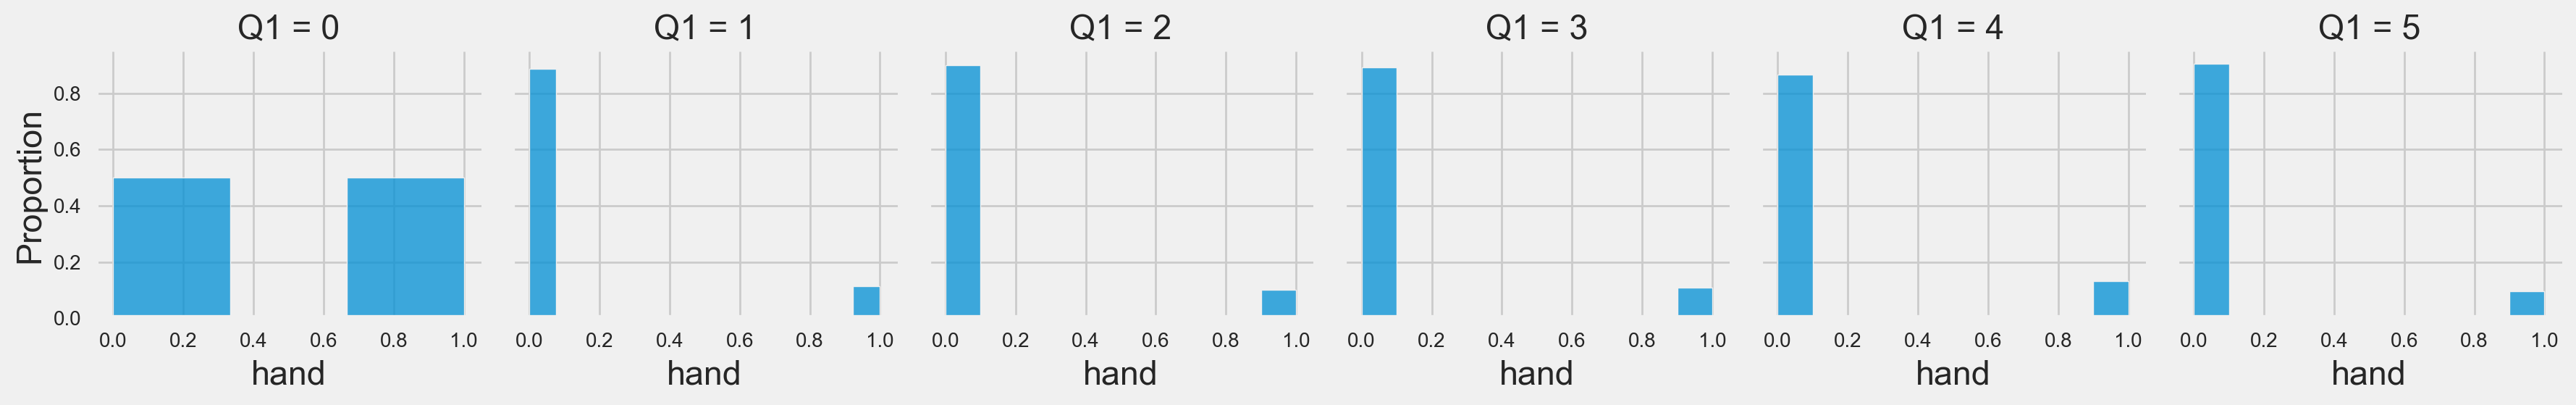

In [52]:
plot = sns.FacetGrid(df, col="Q1")
plot.map(sns.histplot, 'hand', stat = 'proportion');

Answer to question 2

- From a visual inspection of the graphs, it does seem that there is little to no evidence of a difference in the distribution of handedness for different values of Q1.
- We can do a more explicit test (i.e. the Kolmogorov-Smirnov test) to compare distributions.


In [53]:
# Create the necessary place holder variables
corr = 0
p_val = 1
question = ''

# Loop through Q1 to Q44 and find the pearson correlation with the smallest p-value
for i in col_list[0:44]:
    pearson = pearsonr(df[i], df['hand'])
    if pearson[1] < p_val:
        corr = pearson[0]
        p_val = pearson[1]
        question = i

print(f'The question most correlated with handedness is {question} with a pearson value of {corr} and a p-value of {p_val}')

The question most correlated with handedness is Q8 with a pearson value of -0.049803102463642966 and a p-value of 0.0016414999508022907


Answer to question 3

- Q8 has the strongest correlation with handedness. The p-value is significant even at the 0.01 level of significance, but it's also possible that this is just noise. (By testing 44 different questions, it's likely that at least a handful would seem significant just by random chance.)

### BONUS:
Looking for more to do? Probably not - you're busy! But if you want to, consider exploring the following. (They could make for a blog post!)
- Create a visual plot comparing training and test metrics for various values of $k$ and various regularization schemes in logistic regression.
- Rather than just evaluating models based on accuracy, consider using sensitivity, specificity, etc.
- In the context of predicting left-handedness, why are unbalanced classes concerning? If you were to re-do this process given those concerns, what changes might you make?
- Fit and evaluate a generalized linear model other than logistic regression (e.g. Poisson regression).
- Suppose this data were in a `SQL` database named `data` and a table named `inventory`. What `SQL` query would return the count of people who were right-handed, left-handed, both, or missing with their class labels of 1, 2, 3, and 0, respectively? (You can assume you've already logged into the database.)

#### Note

I shall reuse my 'best' logistic regression model and plot a confusion matrix. I will also calculate the precision, recall, f1 score and plot the ROC curve.

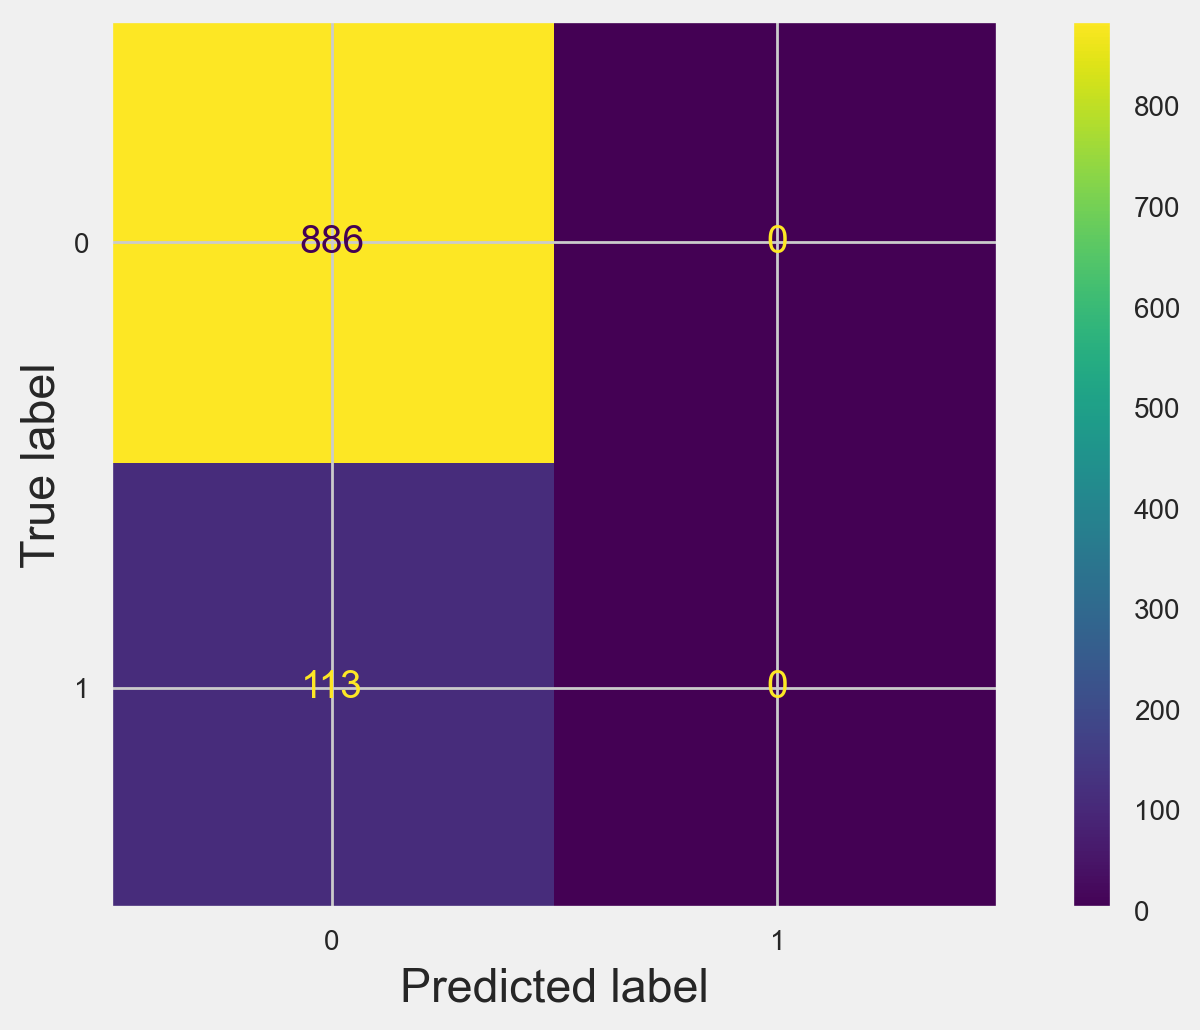

In [54]:
# Instantiate our logistic regression model
logreg = LogisticRegression(penalty = 'l2', C = 0.1, solver='newton-cg')
# Fit our logistic regression model on the training data
logreg.fit(X_train, y_train)
# Make predictions using our logistic regression model
pred = logreg.predict(X_test)
# Create a confusion matrix
cm = confusion_matrix(y_test, pred)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot();

#### Note

Given the fact that there are no true positives, the calculation of recall and precision is merely for show. I did not bother with the F1 score in this case.

In [55]:
# Get precision score
precision = precision_score(y_test, pred)
precision

C:\Users\Wes\mambaforge\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [56]:
# Get recall score
recall = recall_score(y_test, pred)
recall

0.0

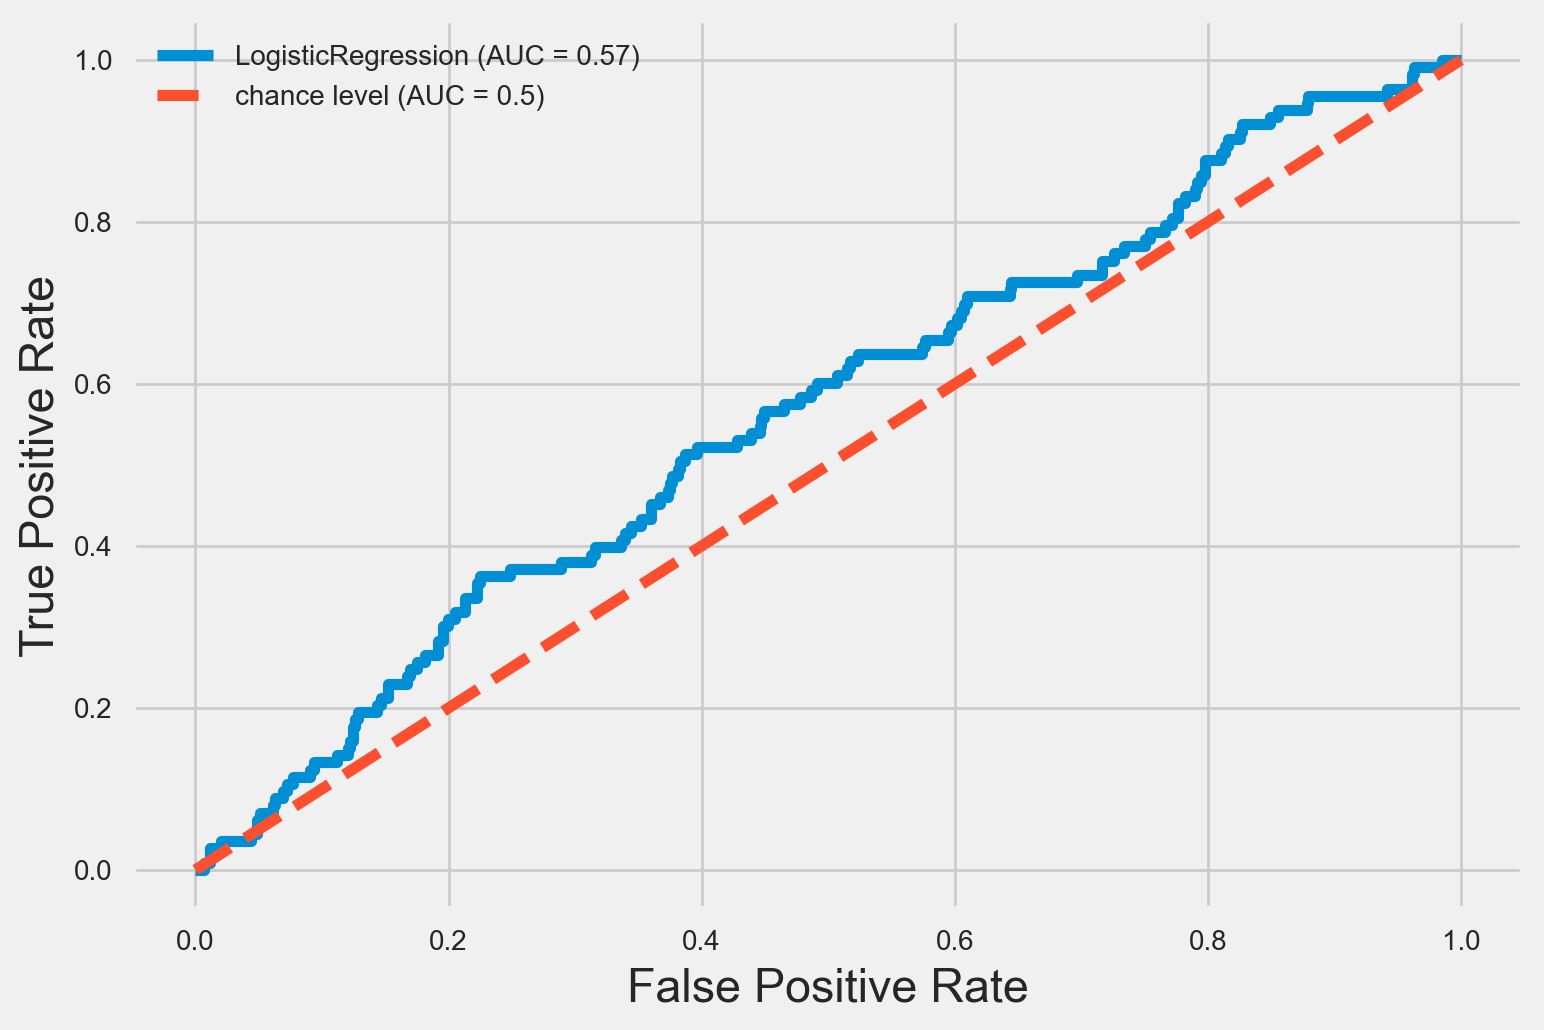

In [57]:
# Create the ROC curve
RocCurveDisplay.from_estimator(logreg, X_test, y_test)
plt.plot([0, 1], [0, 1], "--", label="chance level (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

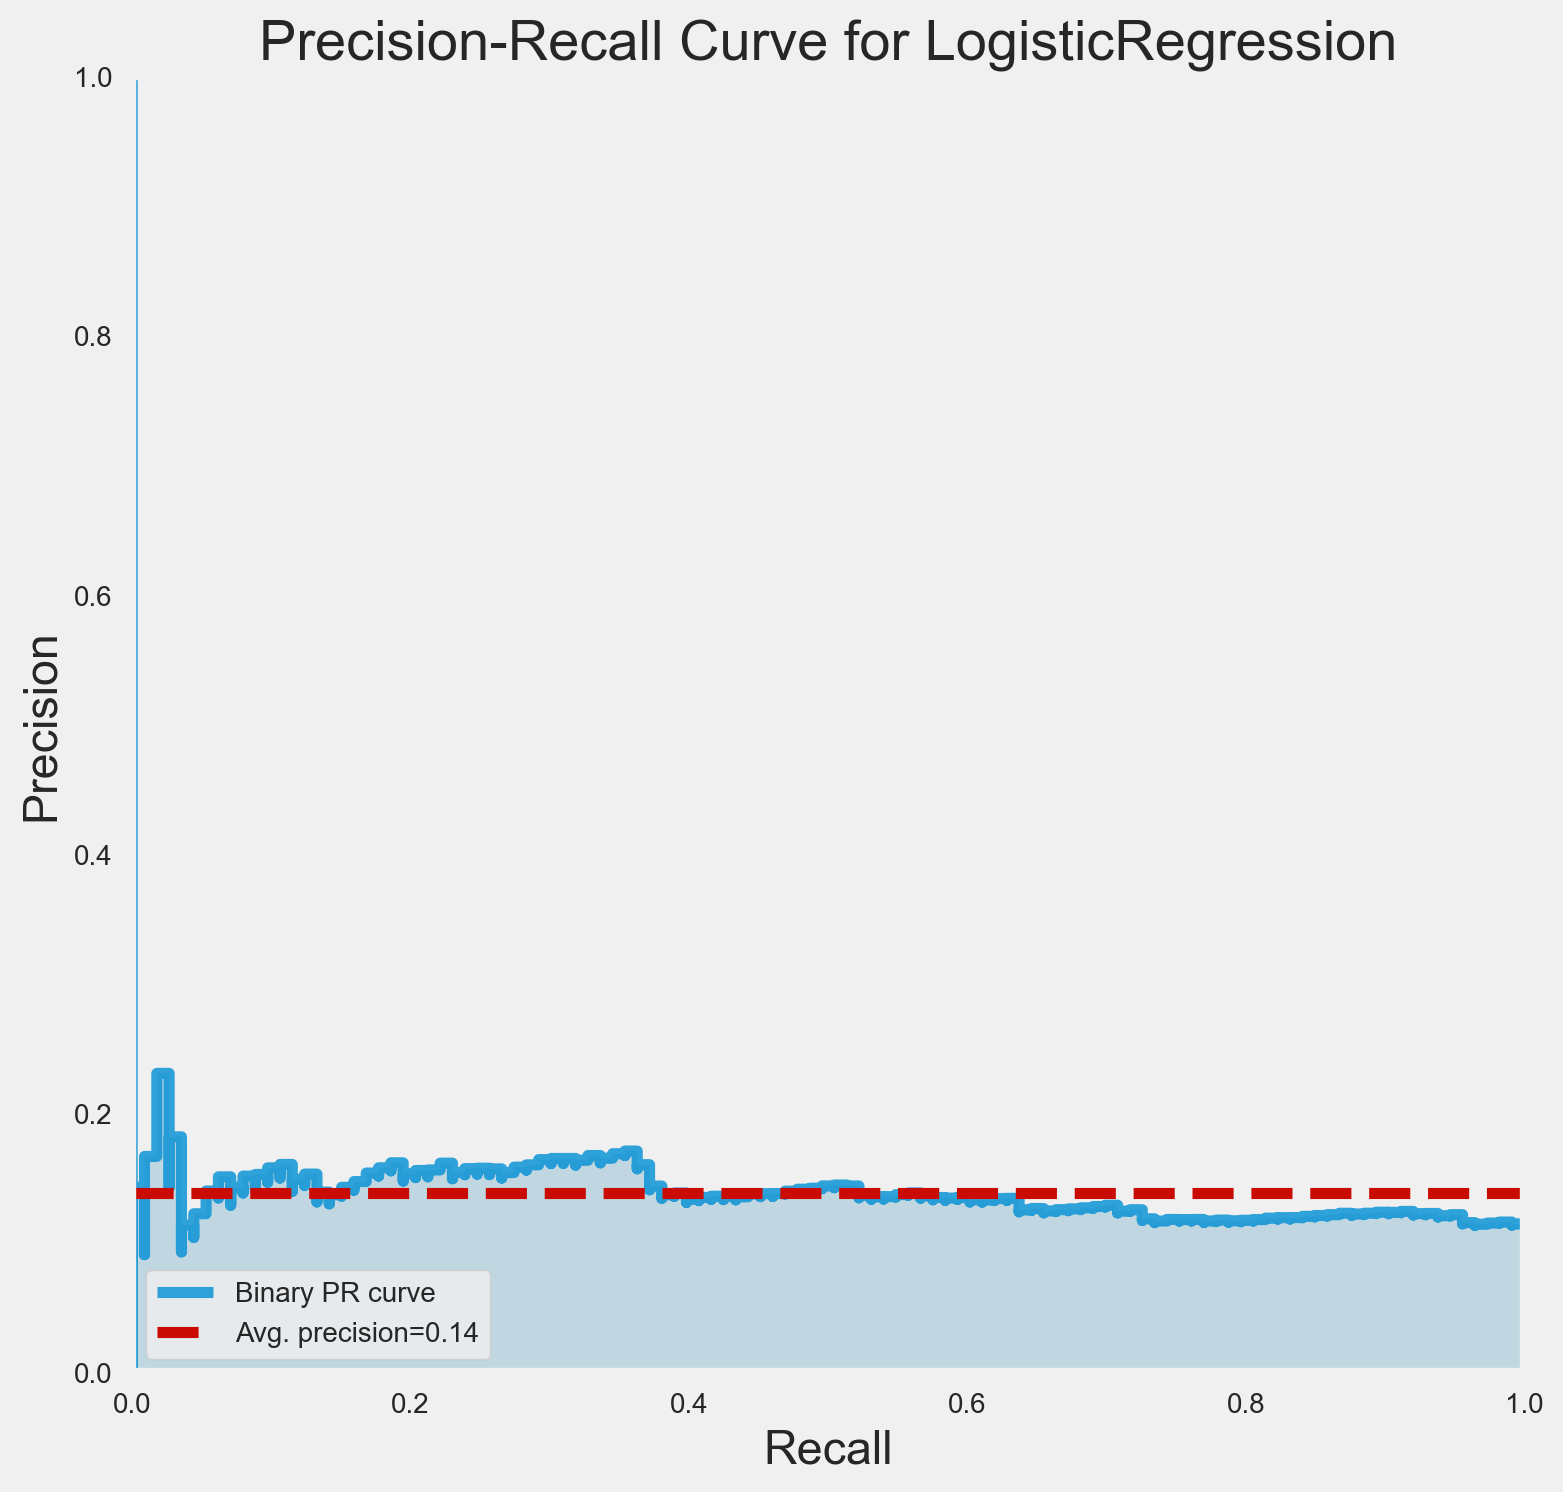

In [58]:
# Create a precision-recall curve
fig, ax = plt.subplots(figsize=(8, 8))
viz = PrecisionRecallCurve(LogisticRegression(penalty = 'l2', C = 0.1, solver='newton-cg'))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof();

#### Note

I knew there was something fishy about the accuracy score for this imbalanced data set. After all the accuracy score converged to the same value as the normalised value_count of the majority class.

Just for 'research' purposes I will repeat the process with one of the KNN models.

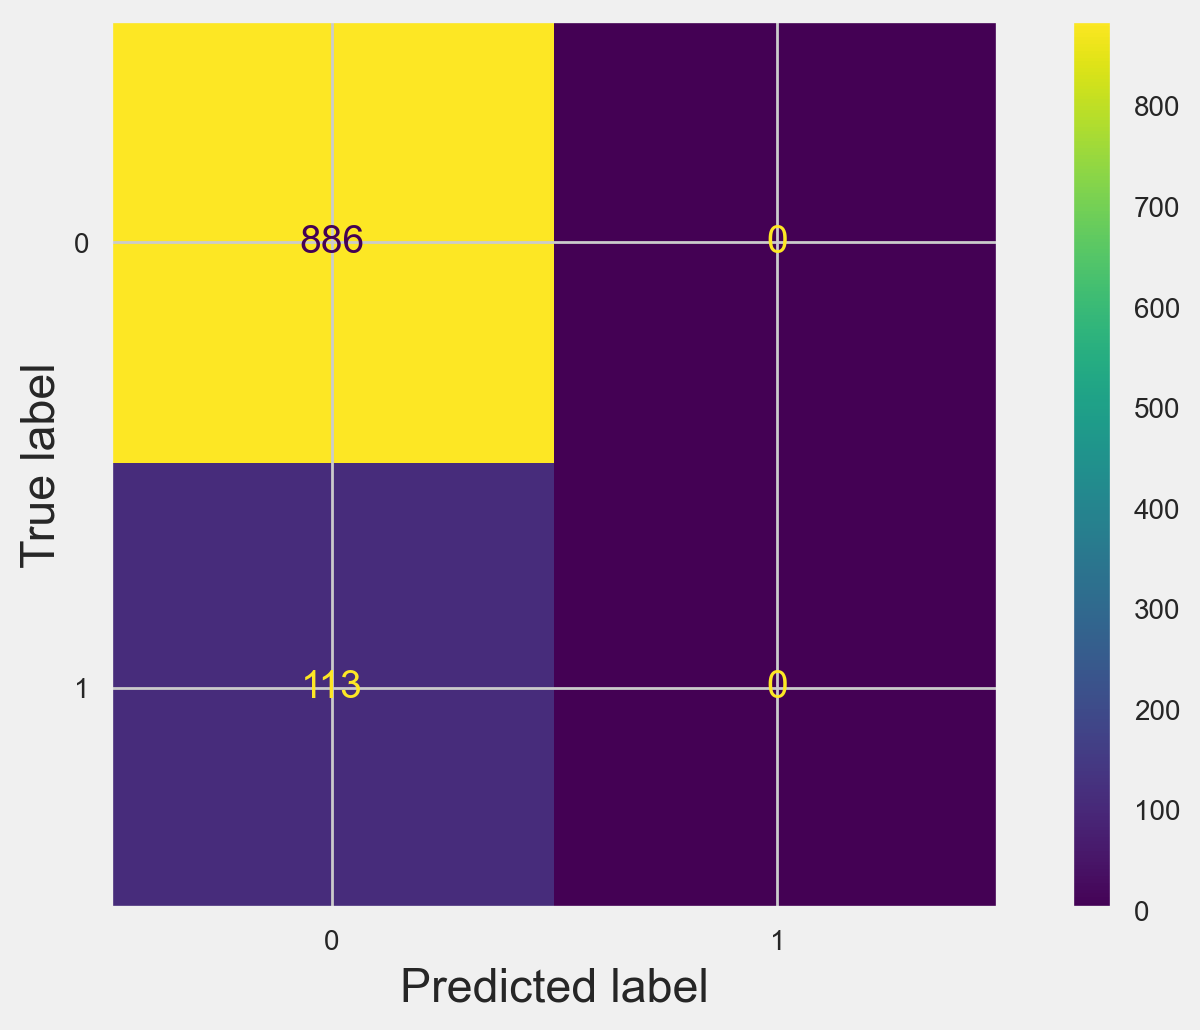

In [59]:
# Instantiate our knn model
knn = KNeighborsClassifier(n_neighbors=15)
# Fit our KNN model on the training data
knn.fit(X_train, y_train)
# Make predictions using our KNN model
pred = knn.predict(X_test)
# Create a confusion matrix
cm = confusion_matrix(y_test, pred)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot();

In [60]:
# Get precision score
precision = precision_score(y_test, pred)
precision

C:\Users\Wes\mambaforge\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [61]:
# Get recall score
recall = recall_score(y_test, pred)
recall

0.0

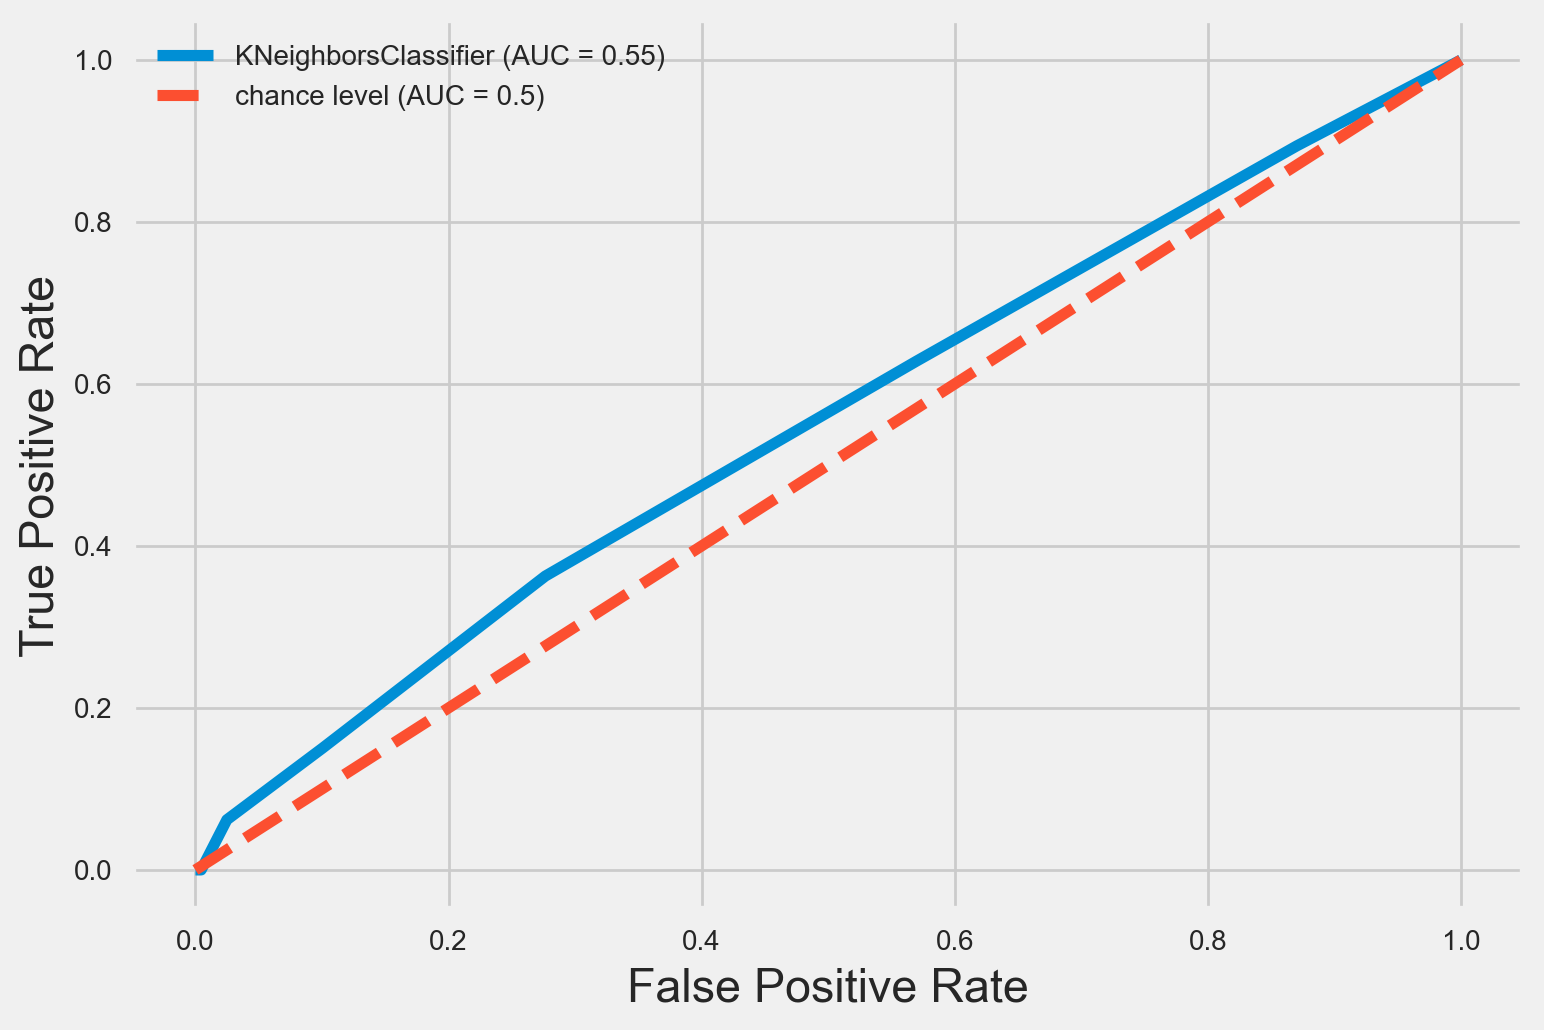

In [62]:
# Create the ROC curve
RocCurveDisplay.from_estimator(knn, X_test, y_test)
plt.plot([0, 1], [0, 1], "--", label="chance level (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

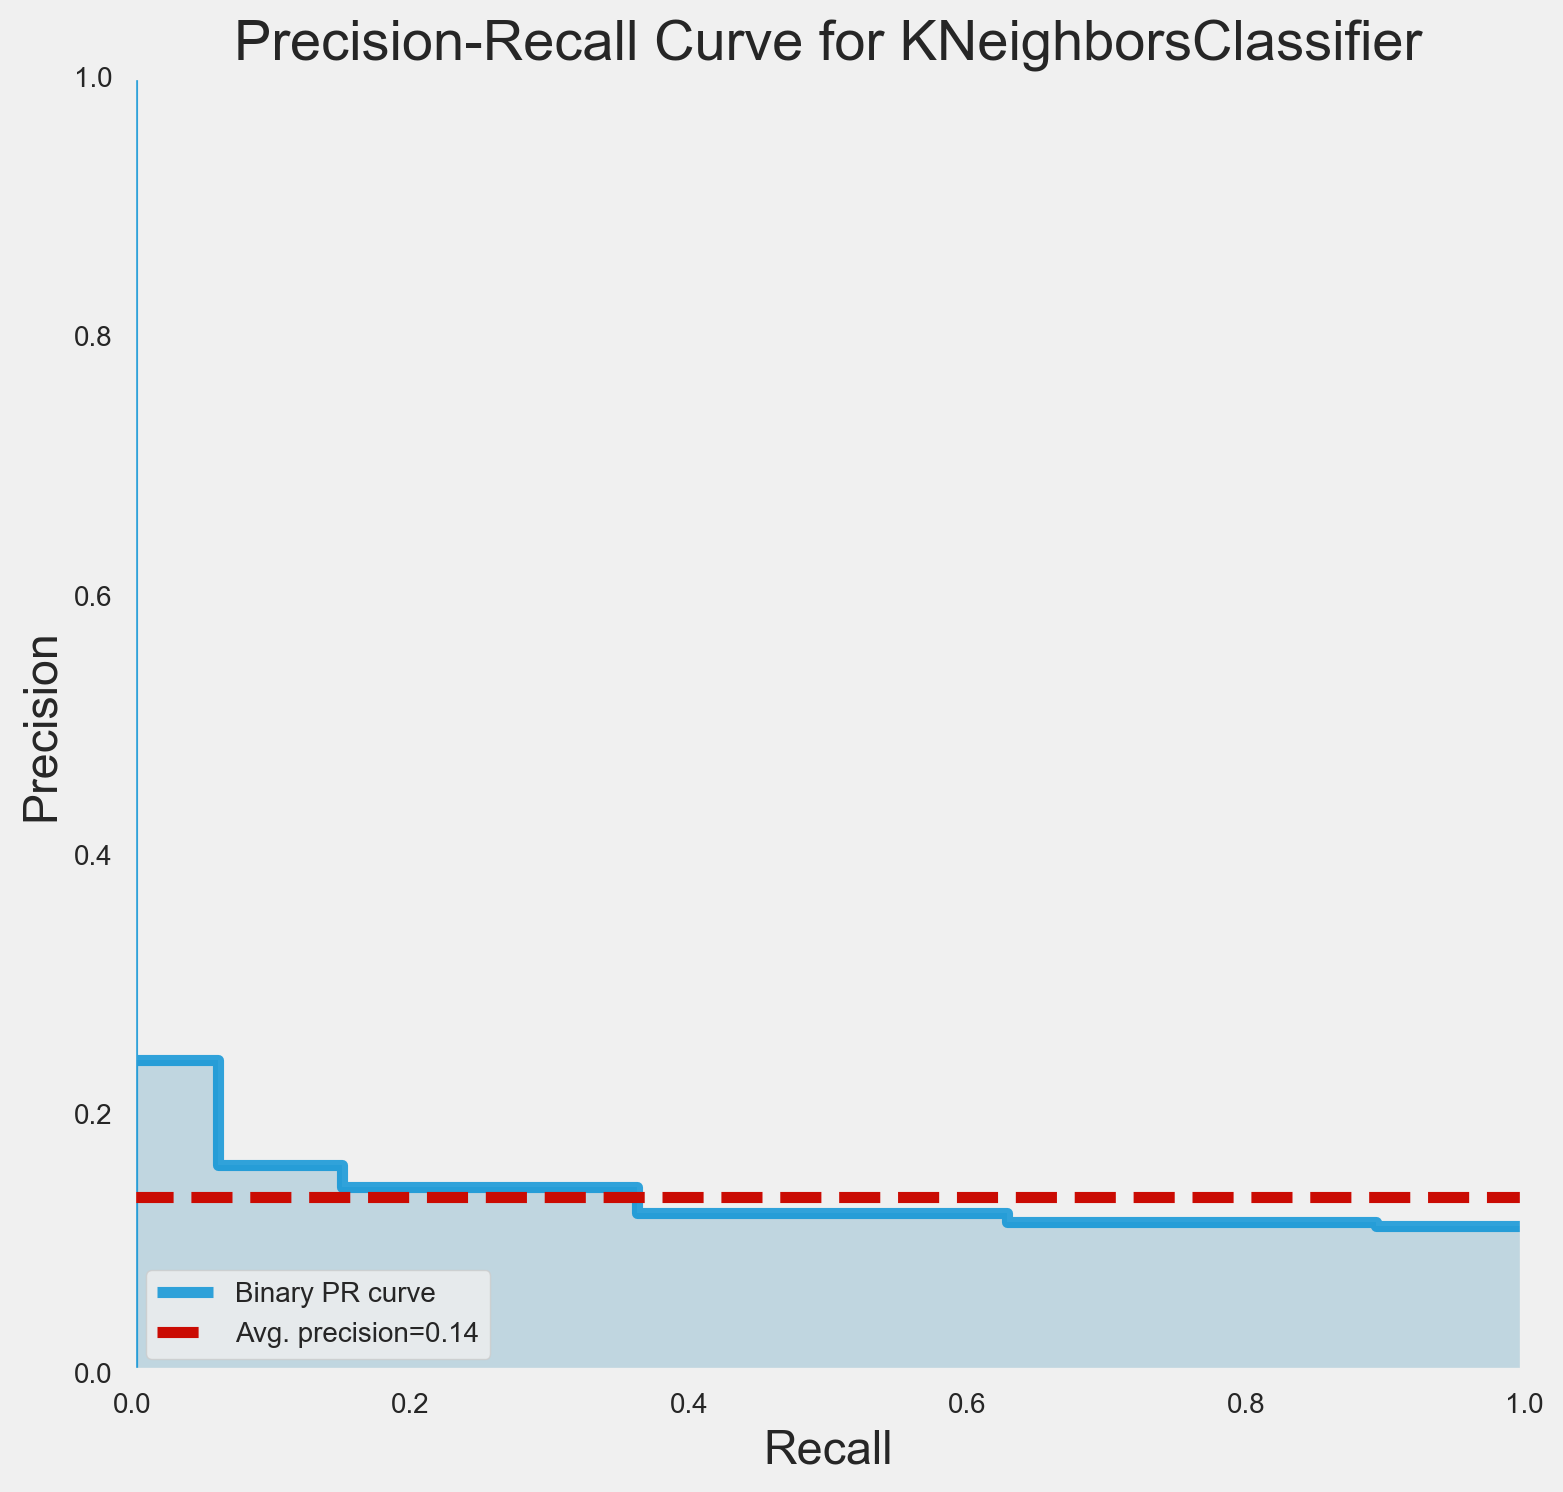

In [63]:
# Create a precision-recall curve
fig, ax = plt.subplots(figsize=(8, 8))
viz = PrecisionRecallCurve(KNeighborsClassifier(n_neighbors=15))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof();

#### Note

Again we see the same problem with our logistic regression model, our models have achieved their high accuracy score by simply predicting every outcome as 'righthanded'. I shall now repeat the process with a gaussian naive bayes model and see if anything changes..

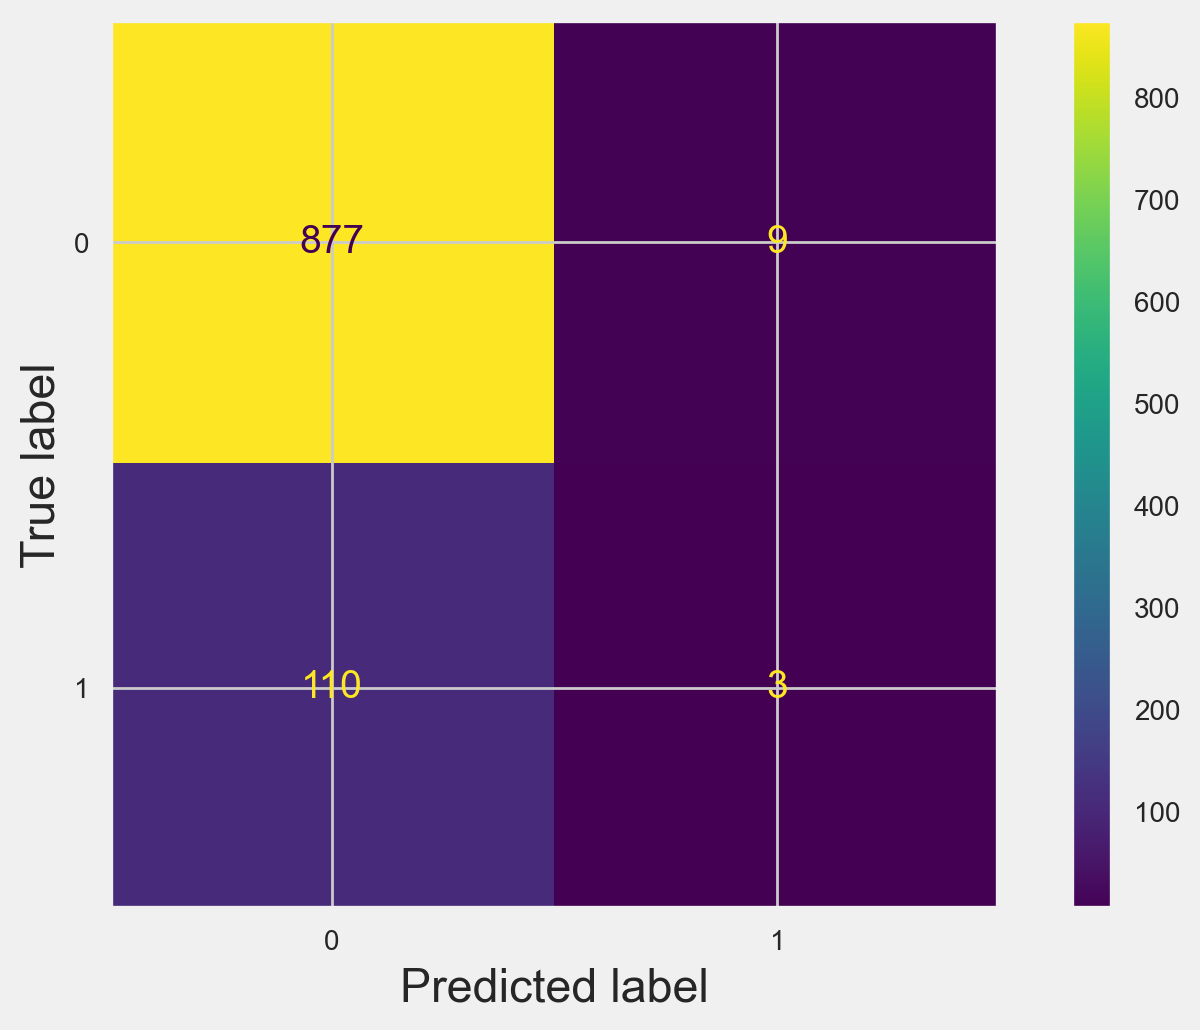

In [64]:
# Instantiate our naive bayes model
naive = GaussianNB()
# Fit our naive bayes model on the training data
naive.fit(X_train, y_train)
# Make predictions using our naive bayes model
pred = naive.predict(X_test)
# Create a confusion matrix
cm = confusion_matrix(y_test, pred)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot();

In [65]:
# Get precision score
precision = precision_score(y_test, pred)
precision

0.25

In [66]:
# Get recall score
recall = recall_score(y_test, pred)
recall

0.02654867256637168

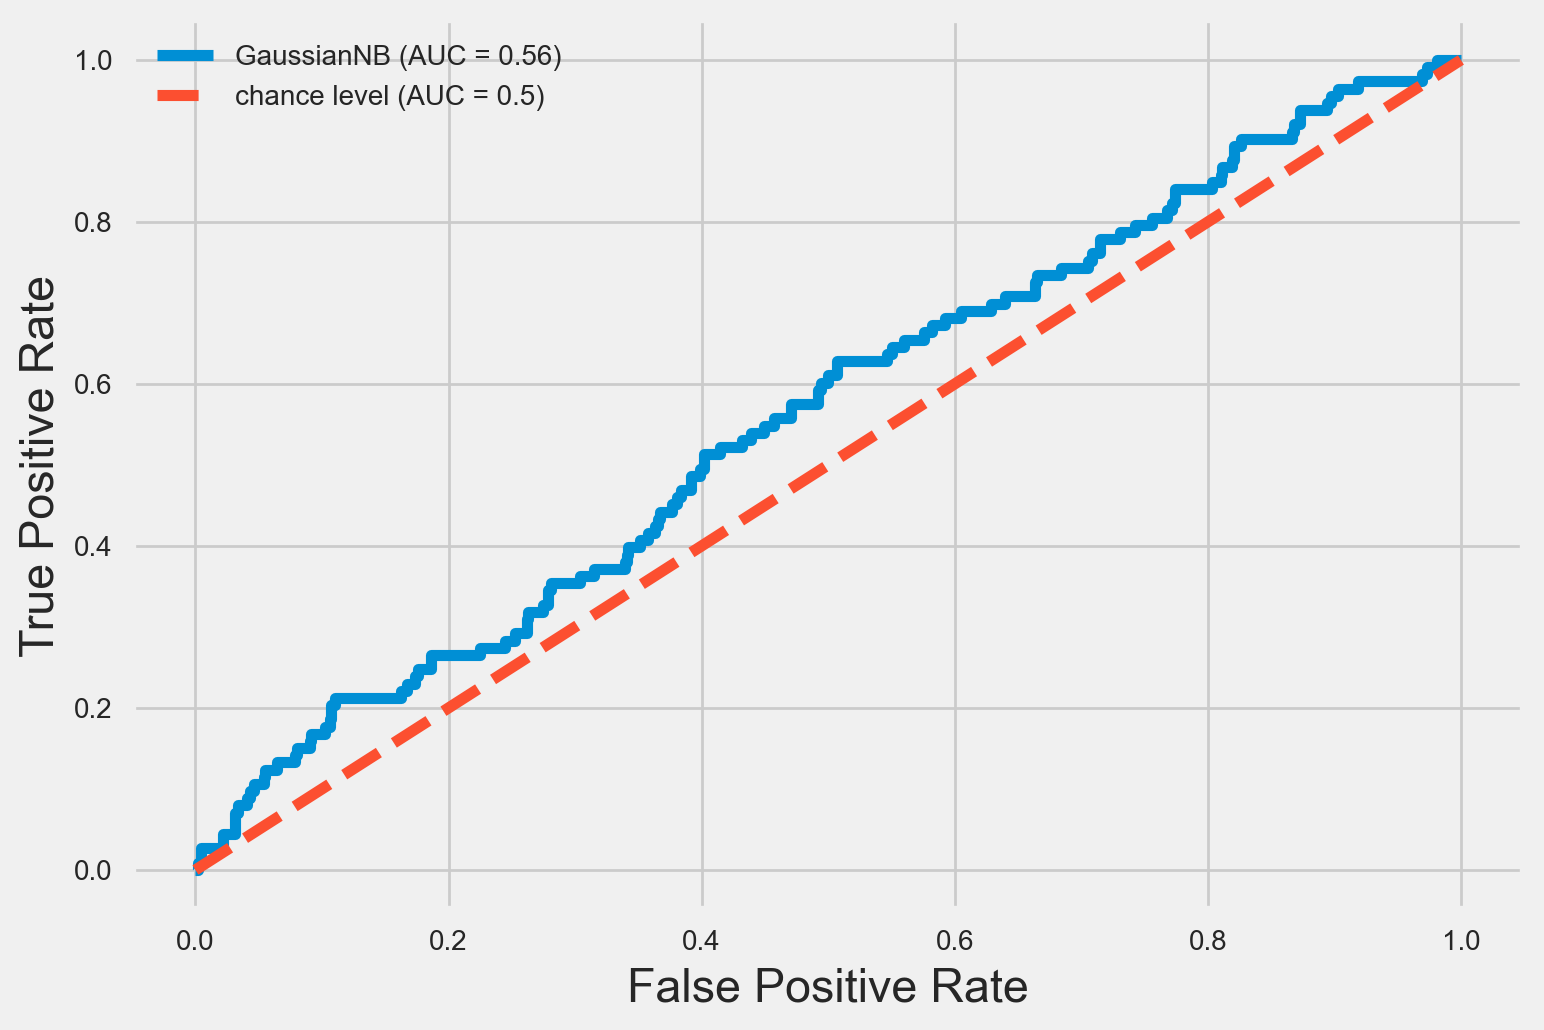

In [67]:
# Create the ROC curve
RocCurveDisplay.from_estimator(naive, X_test, y_test)
plt.plot([0, 1], [0, 1], "--", label="chance level (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

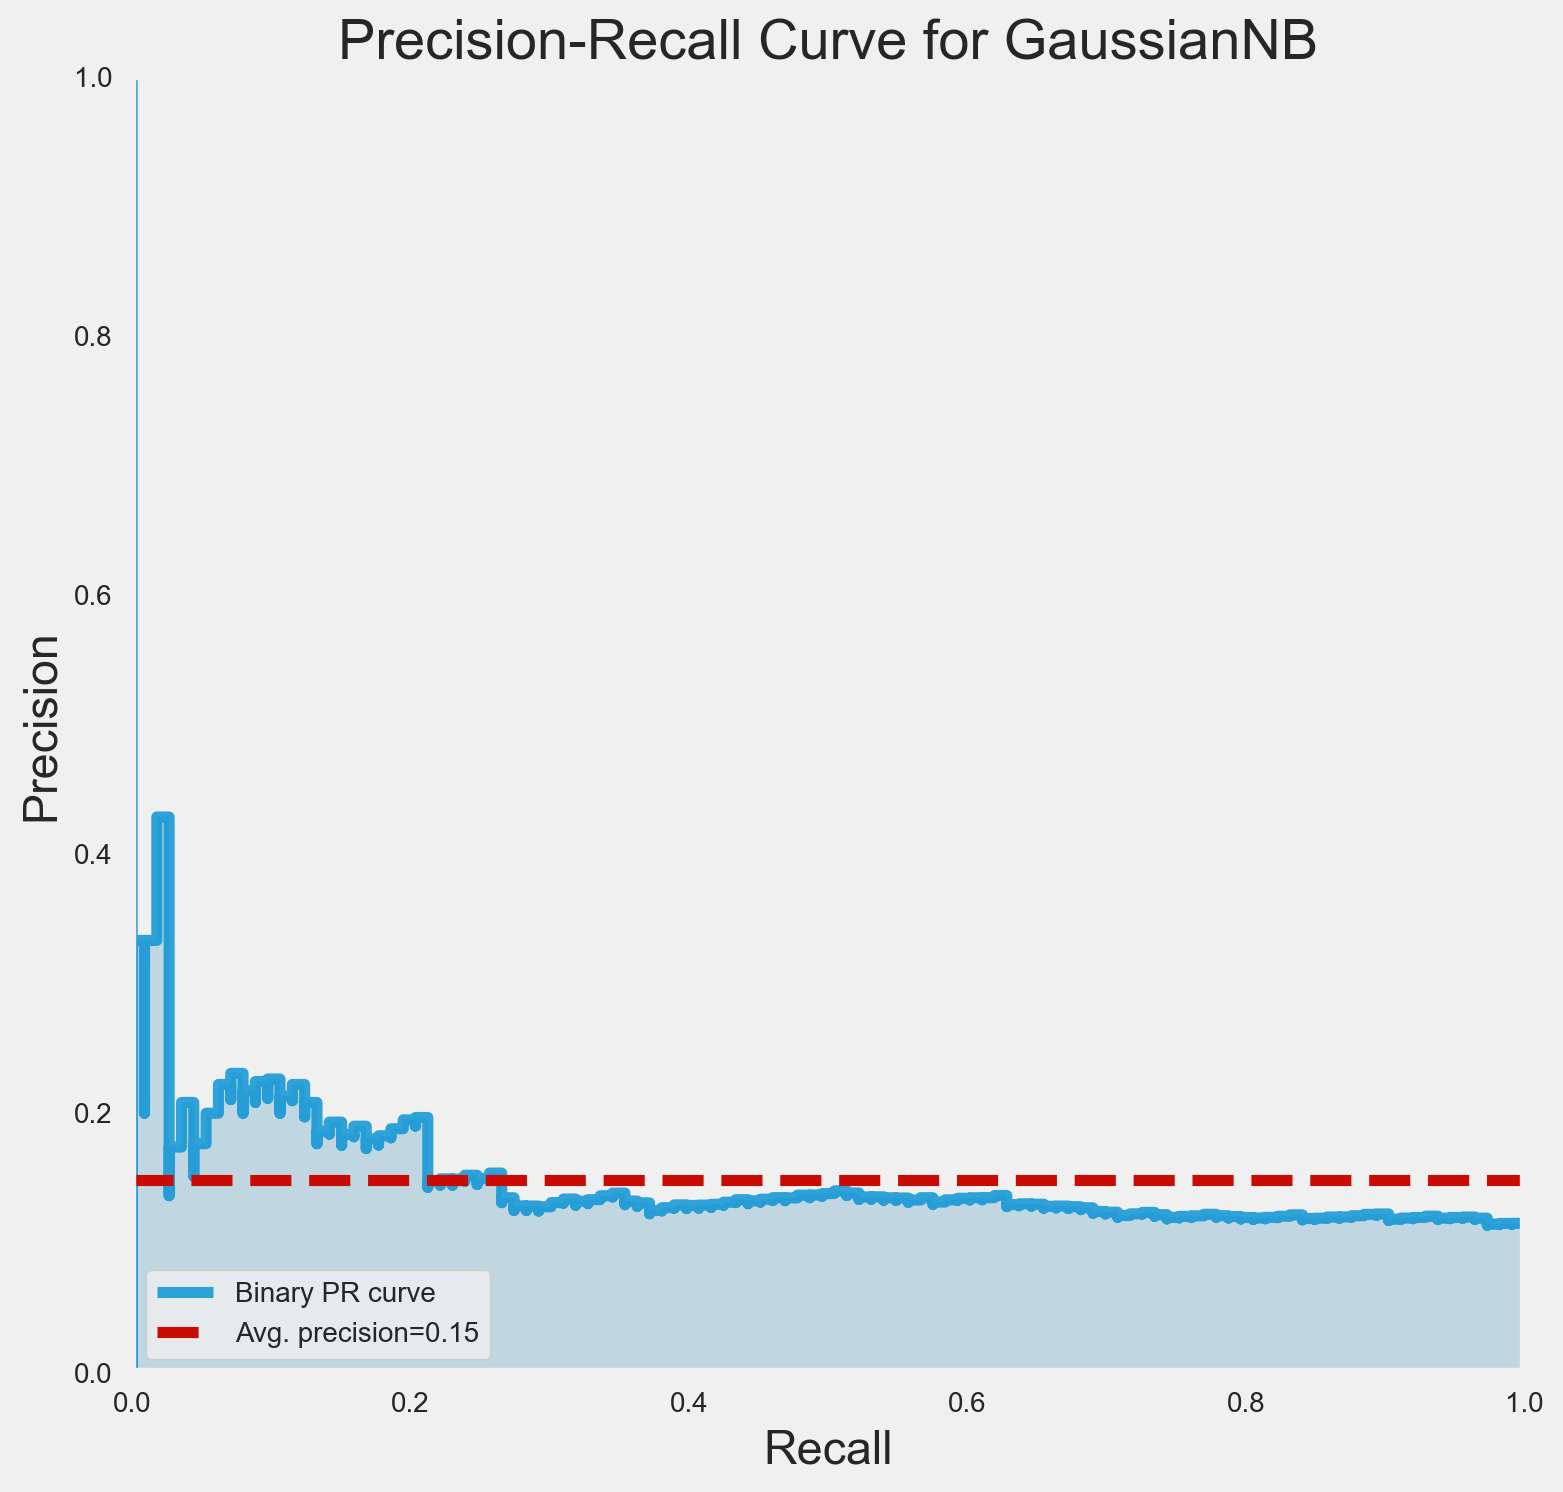

In [68]:
# Create a precision-recall curve
fig, ax = plt.subplots(figsize=(8, 8))
viz = PrecisionRecallCurve(GaussianNB())
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof();

#### Note

There is some improvement compared to our logistic regression and KNN model, although I would hardly dare use this model to make any prediction. The precision score is only 25%, so only 1/4 of those labelled as left-handed are actually left-handed. We have an abysmal recall score of 2.65%, which is to say our model is barely predicting 3 out of every 100 lefthanded persons as actually being lefthanded.

Now, I have decided to address the imbalance of classes by upsampling the minority (lefthandedness) class.

In [69]:
# Create our train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123, stratify = y)

In [70]:
# Combining X_train and y_train into one dataframe for resampling
training_set = pd.concat([X_train, y_train], axis=1) 
# Create a dataframe with rows where the respondent is left-handed
left_hand = training_set[training_set['hand']==1]
# Create a dataframe with rows where the respondent is right-handed
right_hand = training_set[training_set['hand']==0]
# Resample our minority class with replacement up to the number of rows of the majority class
oversample = resample(left_hand, replace=True, n_samples=len(right_hand), random_state=123) 
# Concatenate resampled dataframe and majority class dataframe
oversample_train = pd.concat([right_hand, oversample])
# Assign our features matrix to X_train 
X_train = oversample_train.drop('hand', axis=1)
# Assign our target matrix to y_train
y_train = oversample_train['hand']
# Check for class imbalance, we fixed it
y_train.value_counts()

hand
0    2656
1    2656
Name: count, dtype: int64

#### Note

The below code cell shows another way to oversample the minority class using RandomOverSampler from imblearn.over_sampling. I have commented out the code since it is just a duplicate of the resample method I have used.

In [71]:
# # Instantiate the class to oversample the minority class up to the number of rows of the majority class
# ros = RandomOverSampler(sampling_strategy=1.0, random_state=123)
# # Fit this class to our training matrices and assign the output to X_ros and y_ros
# X_ros, y_ros = ros.fit_resample(X_train, y_train)
# # Create our feature matrix
# X_train = X_ros
# # Create our target matrix
# y_train = y_ros
# # Check for class imbalance, we fixed it
# y_train.value_counts()

#### Note

We now have equal proportions of both classes which should improve the performance of our models, if the features have any predictive value on the target of handedness. That's what I'm hoping for anyway.

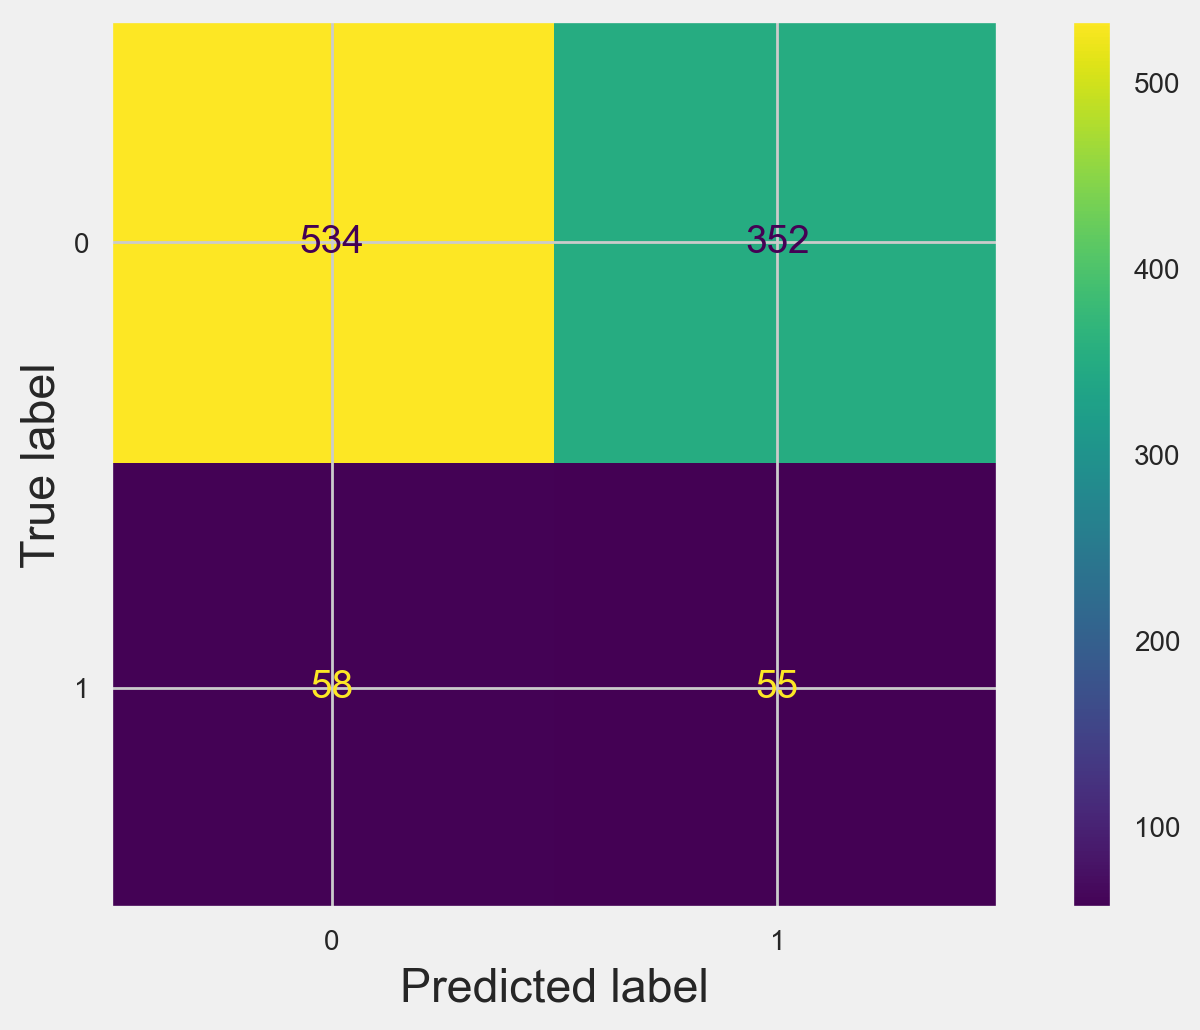

In [72]:
# Instantiate our logistic regression model
logreg = LogisticRegression(penalty = 'l2', C = 0.1, solver='newton-cg')
# Fit our logistic regression model on the training data
logreg.fit(X_train, y_train)
# Make predictions using our logistic regression model
pred = logreg.predict(X_test)
# Create a confusion matrix
cm = confusion_matrix(y_test, pred)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot();

In [73]:
# Get precision score
precision = precision_score(y_test, pred)
precision

0.13513513513513514

In [74]:
# Get recall score
recall = recall_score(y_test, pred)
recall

0.48672566371681414

In [75]:
# Get f1 score
f1_score(y_test, pred)

0.21153846153846154

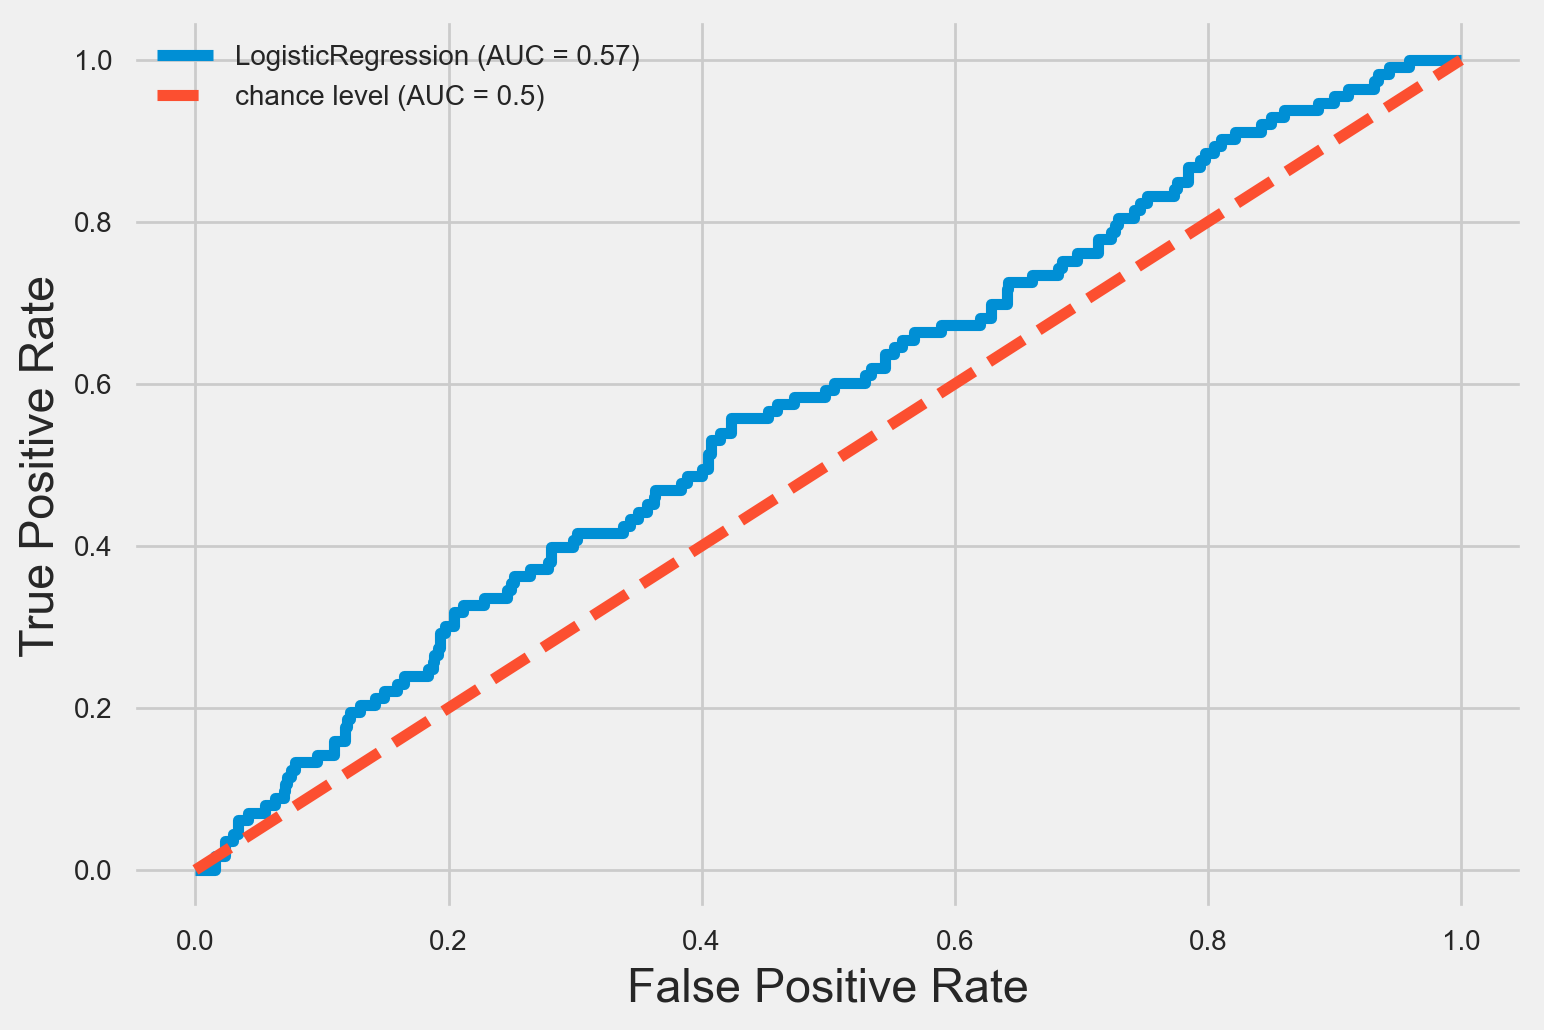

In [76]:
# Create the ROC curve
RocCurveDisplay.from_estimator(logreg, X_test, y_test)
plt.plot([0, 1], [0, 1], "--", label="chance level (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

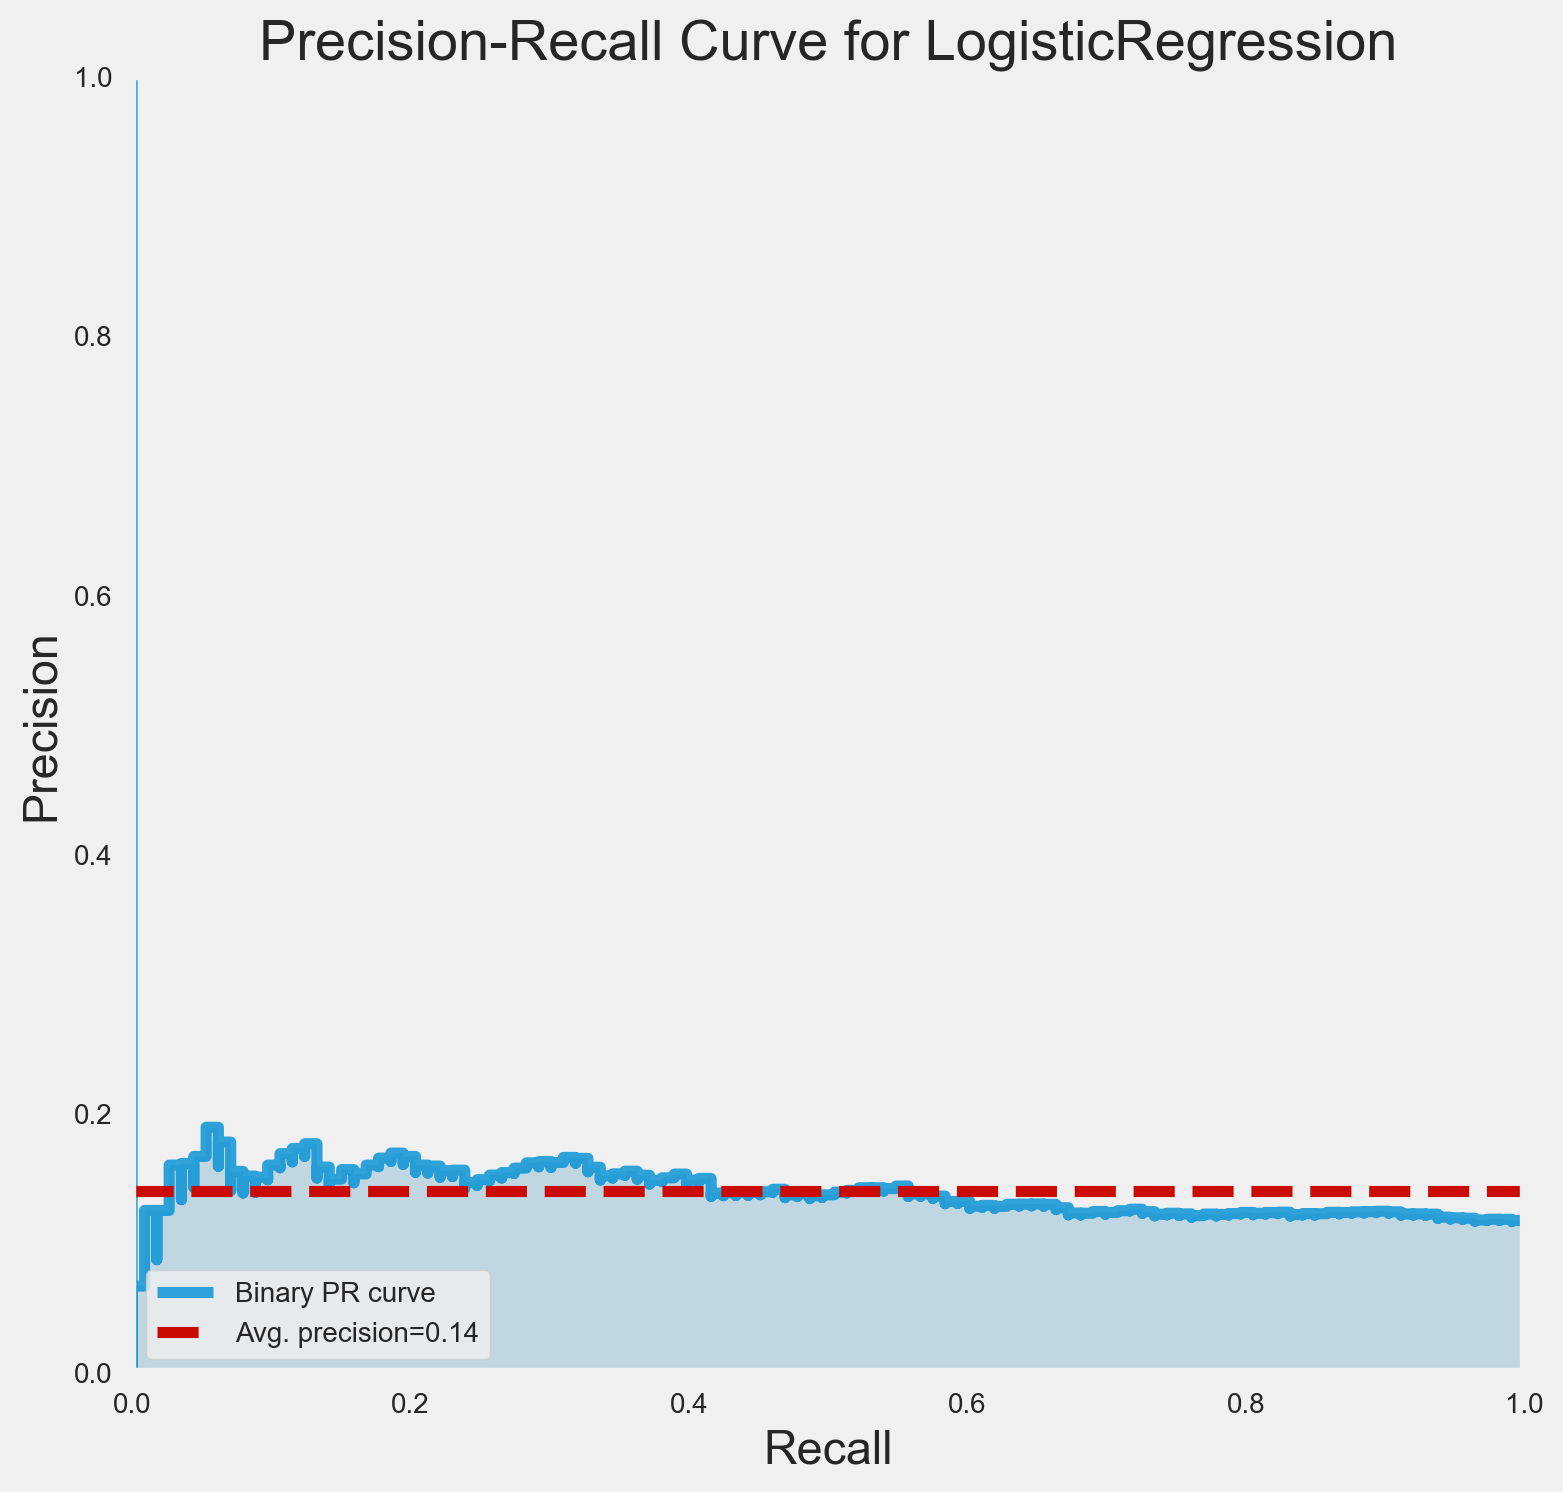

In [77]:
# Create a precision-recall curve
fig, ax = plt.subplots(figsize=(8, 8))
viz = PrecisionRecallCurve(LogisticRegression(penalty = 'l2', C = 0.1, solver='newton-cg'))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof();

#### Note

After upsampling the minority class, we start to see more realistic results from our logistic regression model, but the model is still really quite bad. The AUC is only 0.57 and from our precision-recall curve, we can see that the model is not able to correctly label positives with any measure of reliability.

In [78]:
# Calculate the ROC-AUC for 1 to 25 neighbours
for i in range(1, 26):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    auc_score = roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])
    print(f'For {i} neighbours, the ROC-AUC score is {auc_score}')


For 1 neighbours, the ROC-AUC score is 0.5475039453444934
For 2 neighbours, the ROC-AUC score is 0.5417607223476298
For 3 neighbours, the ROC-AUC score is 0.556608202321261
For 4 neighbours, the ROC-AUC score is 0.5445424399208934
For 5 neighbours, the ROC-AUC score is 0.5485926606604207
For 6 neighbours, the ROC-AUC score is 0.5413062586148345
For 7 neighbours, the ROC-AUC score is 0.5334005873069777
For 8 neighbours, the ROC-AUC score is 0.5259943266945004
For 9 neighbours, the ROC-AUC score is 0.5130545955772189
For 10 neighbours, the ROC-AUC score is 0.5125002497053477
For 11 neighbours, the ROC-AUC score is 0.5132893186040473
For 12 neighbours, the ROC-AUC score is 0.5148275035458161
For 13 neighbours, the ROC-AUC score is 0.5179588086058451
For 14 neighbours, the ROC-AUC score is 0.5244661299666394
For 15 neighbours, the ROC-AUC score is 0.5264238198925268
For 16 neighbours, the ROC-AUC score is 0.5308785632953116
For 17 neighbours, the ROC-AUC score is 0.5328911883976908
For 18 

#### Note

Iterating through 1 to 25 neighbours, we get the best ROC-AUC with 3 neighbours, but the performance is quite terrible still. In fact, the model isn't any better than before upsampling the minority class. Anyway, I shall instantiate a KNN model with 3 neighbours and calculate the various scoring metrics and plot the ROC curve and the precision-recall curve.

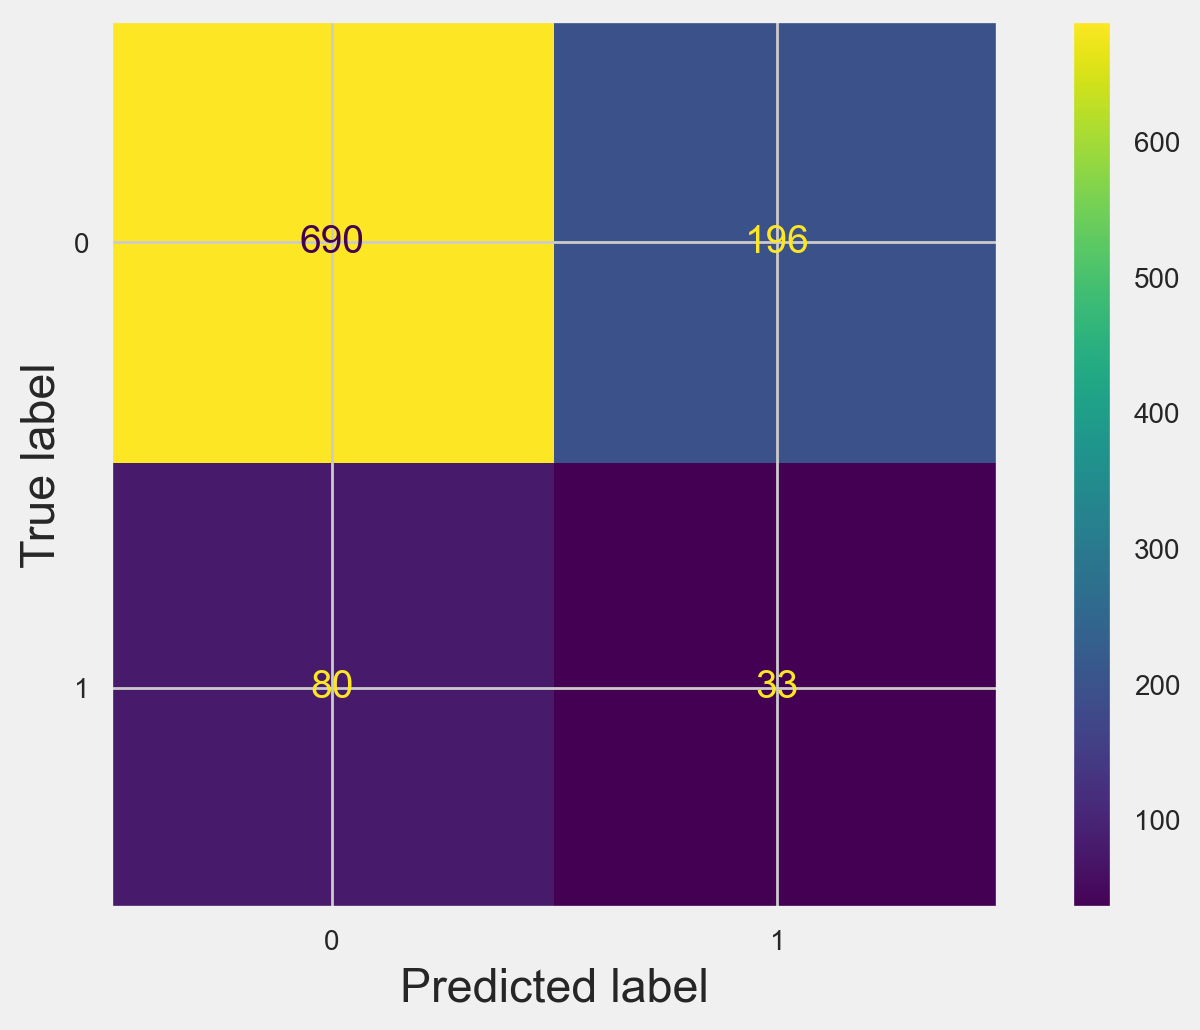

In [79]:
# Instantiate our knn model
knn = KNeighborsClassifier(n_neighbors=3)
# Fit our KNN model on the training data
knn.fit(X_train, y_train)
# Make predictions using our KNN model
pred = knn.predict(X_test)
# Create a confusion matrix
cm = confusion_matrix(y_test, pred)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot();

In [80]:
# Get precision score
precision = precision_score(y_test, pred)
precision

0.14410480349344978

In [81]:
# Get recall score
recall = recall_score(y_test, pred)
recall

0.2920353982300885

In [82]:
# Get f1 score
f1_score(y_test, pred)

0.1929824561403509

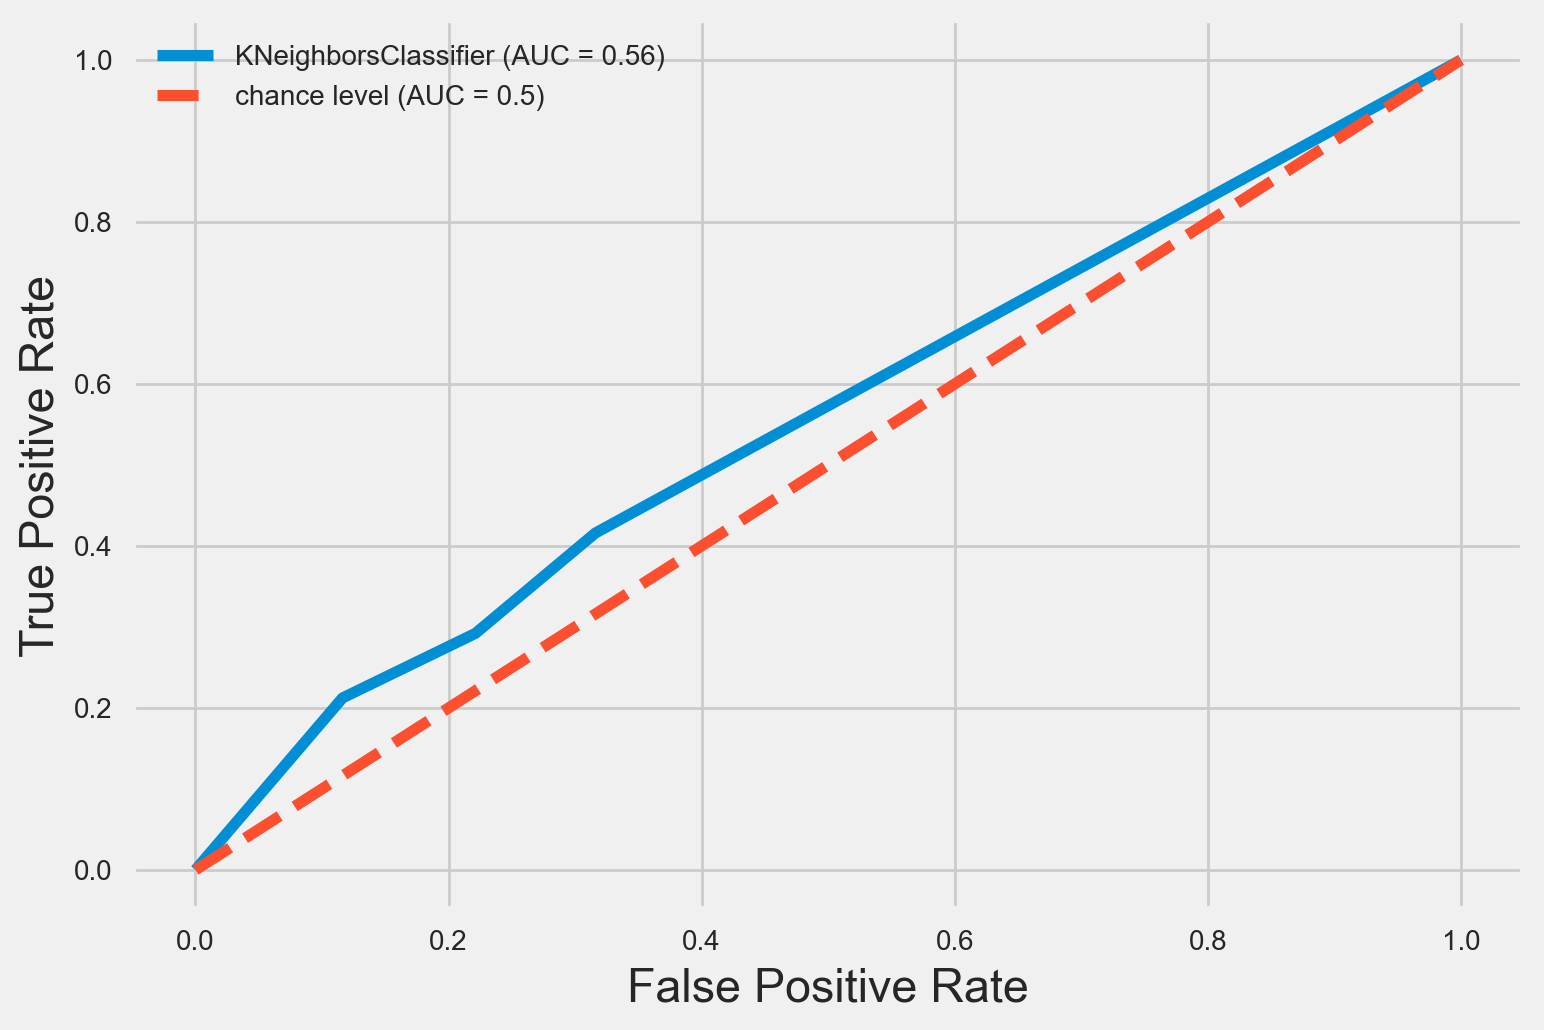

In [83]:
# Create the ROC curve
RocCurveDisplay.from_estimator(knn, X_test, y_test)
plt.plot([0, 1], [0, 1], "--", label="chance level (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

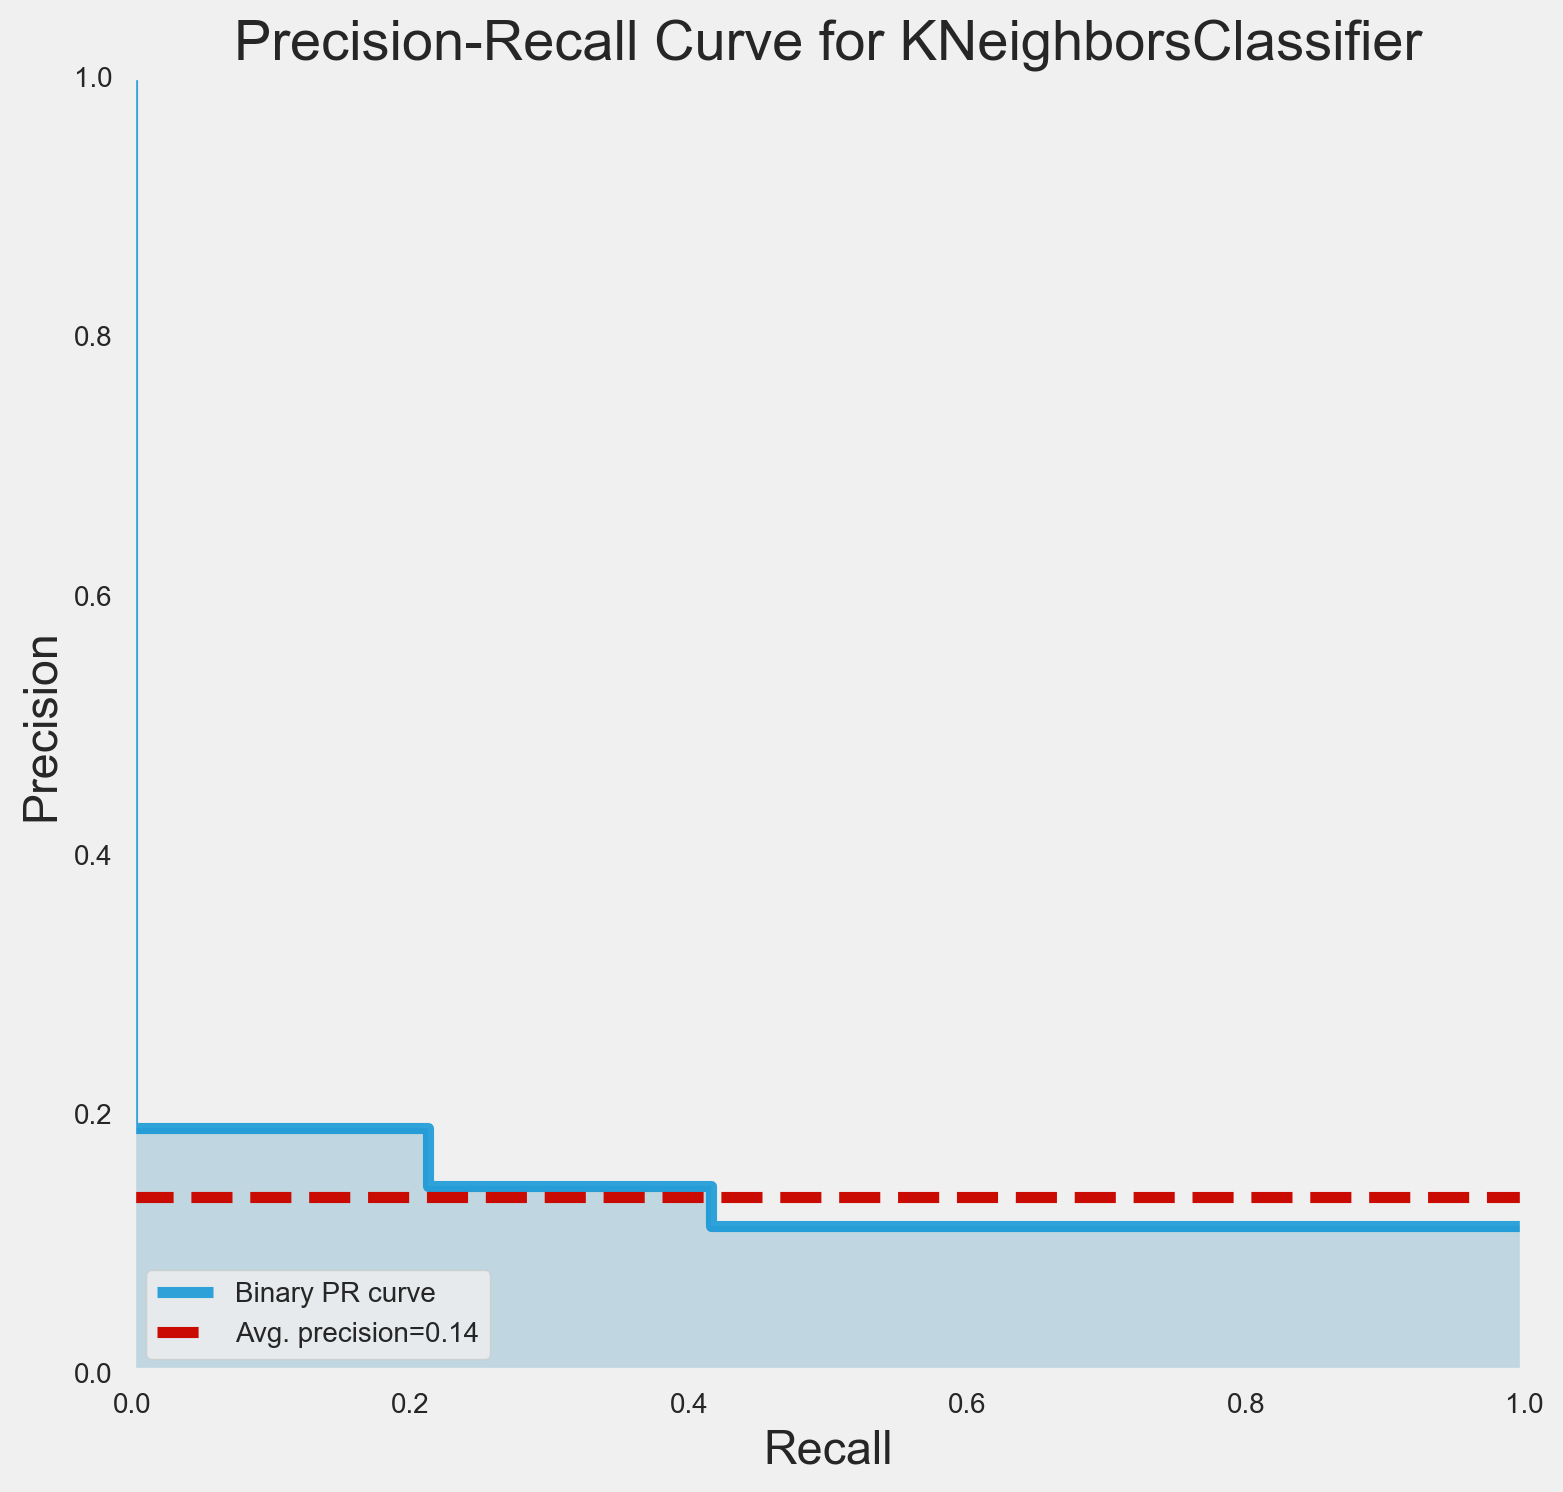

In [84]:
# Create a precision-recall curve
fig, ax = plt.subplots(figsize=(8, 8))
viz = PrecisionRecallCurve(KNeighborsClassifier(n_neighbors=3))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof();

#### Note

Compared to the logistic regression model, our KNN model with 3 neighbours has just a bad AUC score of about 0.56. Adjusting the discrimination threshold does not really improve precision or recall. In fact we are better off not upsampling the minority class.

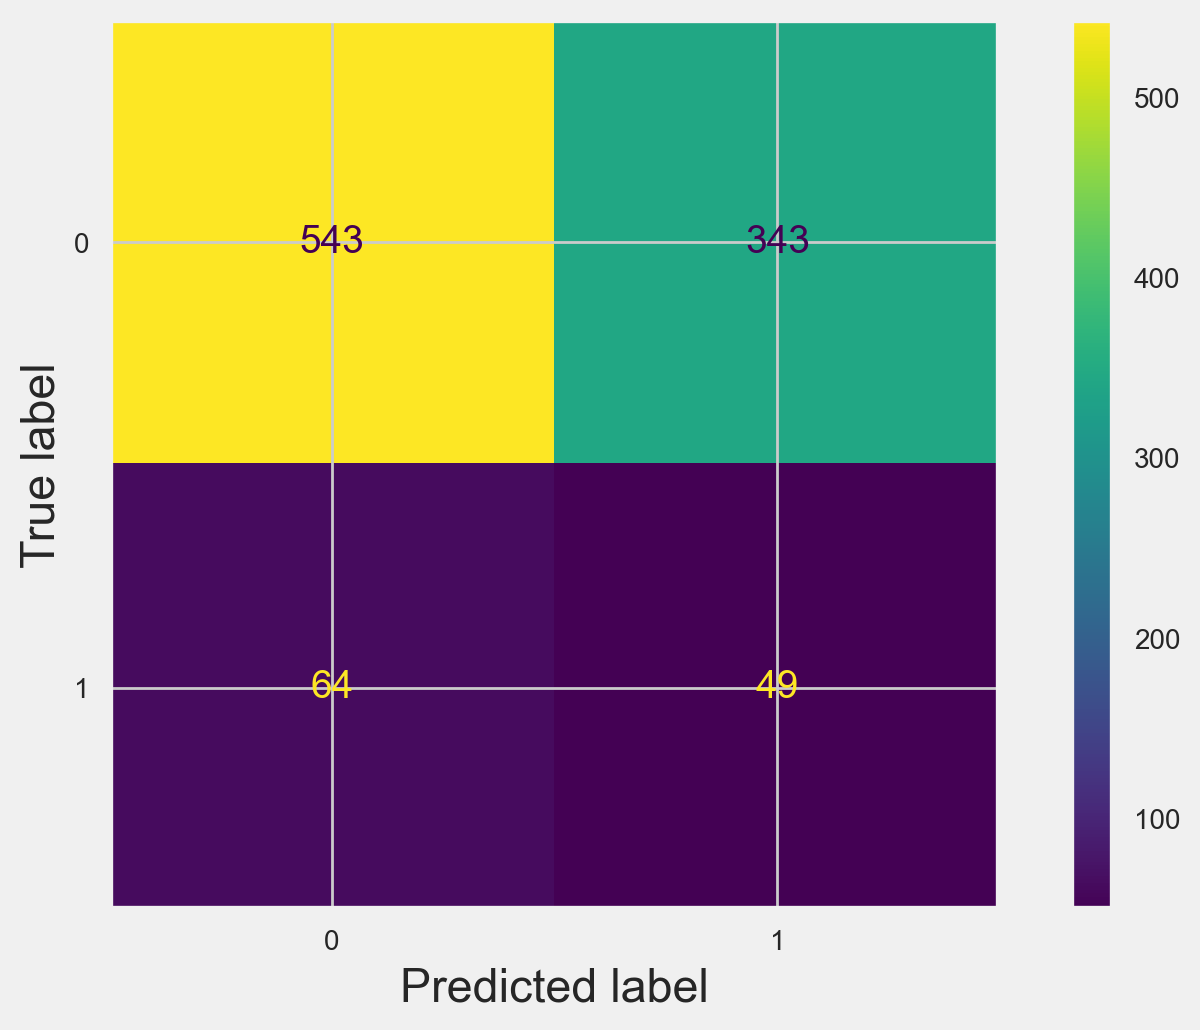

In [85]:
# Instantiate our naive bayes model
naive = GaussianNB()
# Fit our naive bayes model on the training data
naive.fit(X_train, y_train)
# Make predictions using our naive bayes model
pred = naive.predict(X_test)
# Create a confusion matrix
cm = confusion_matrix(y_test, pred)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot();

In [86]:
# Get precision score
precision = precision_score(y_test, pred)
precision

0.125

In [87]:
# Get recall score
recall = recall_score(y_test, pred)
recall

0.4336283185840708

In [88]:
# Get f1 score
f1_score(y_test, pred)

0.19405940594059407

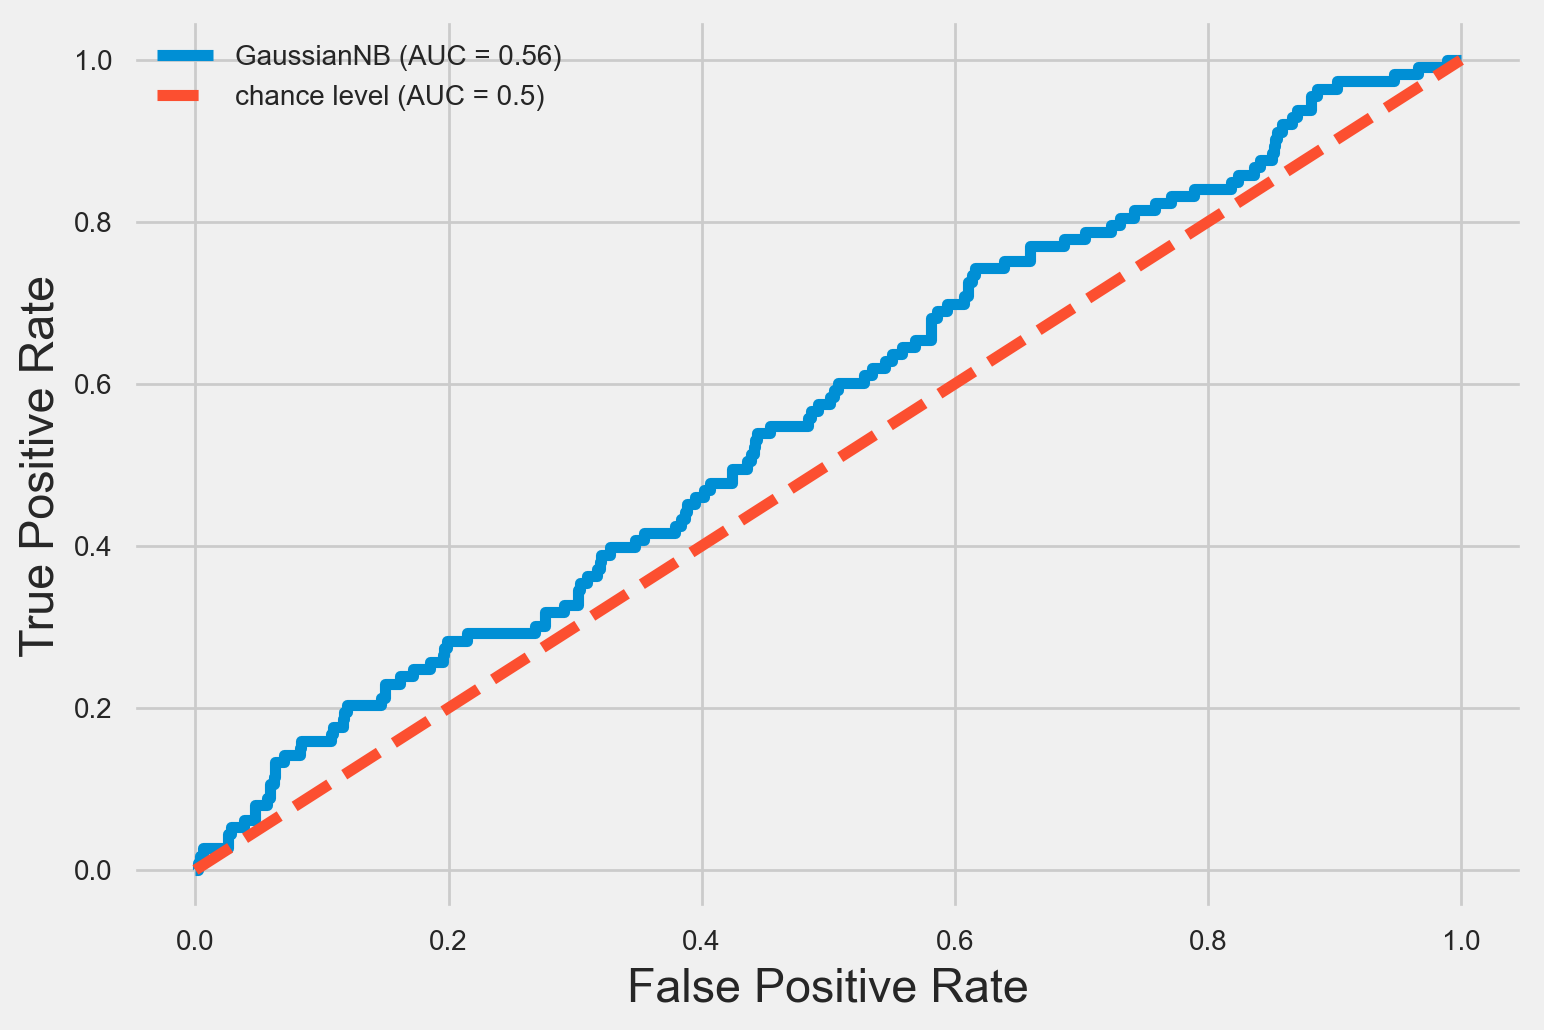

In [89]:
# Create the ROC curve
RocCurveDisplay.from_estimator(naive, X_test, y_test)
plt.plot([0, 1], [0, 1], "--", label="chance level (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

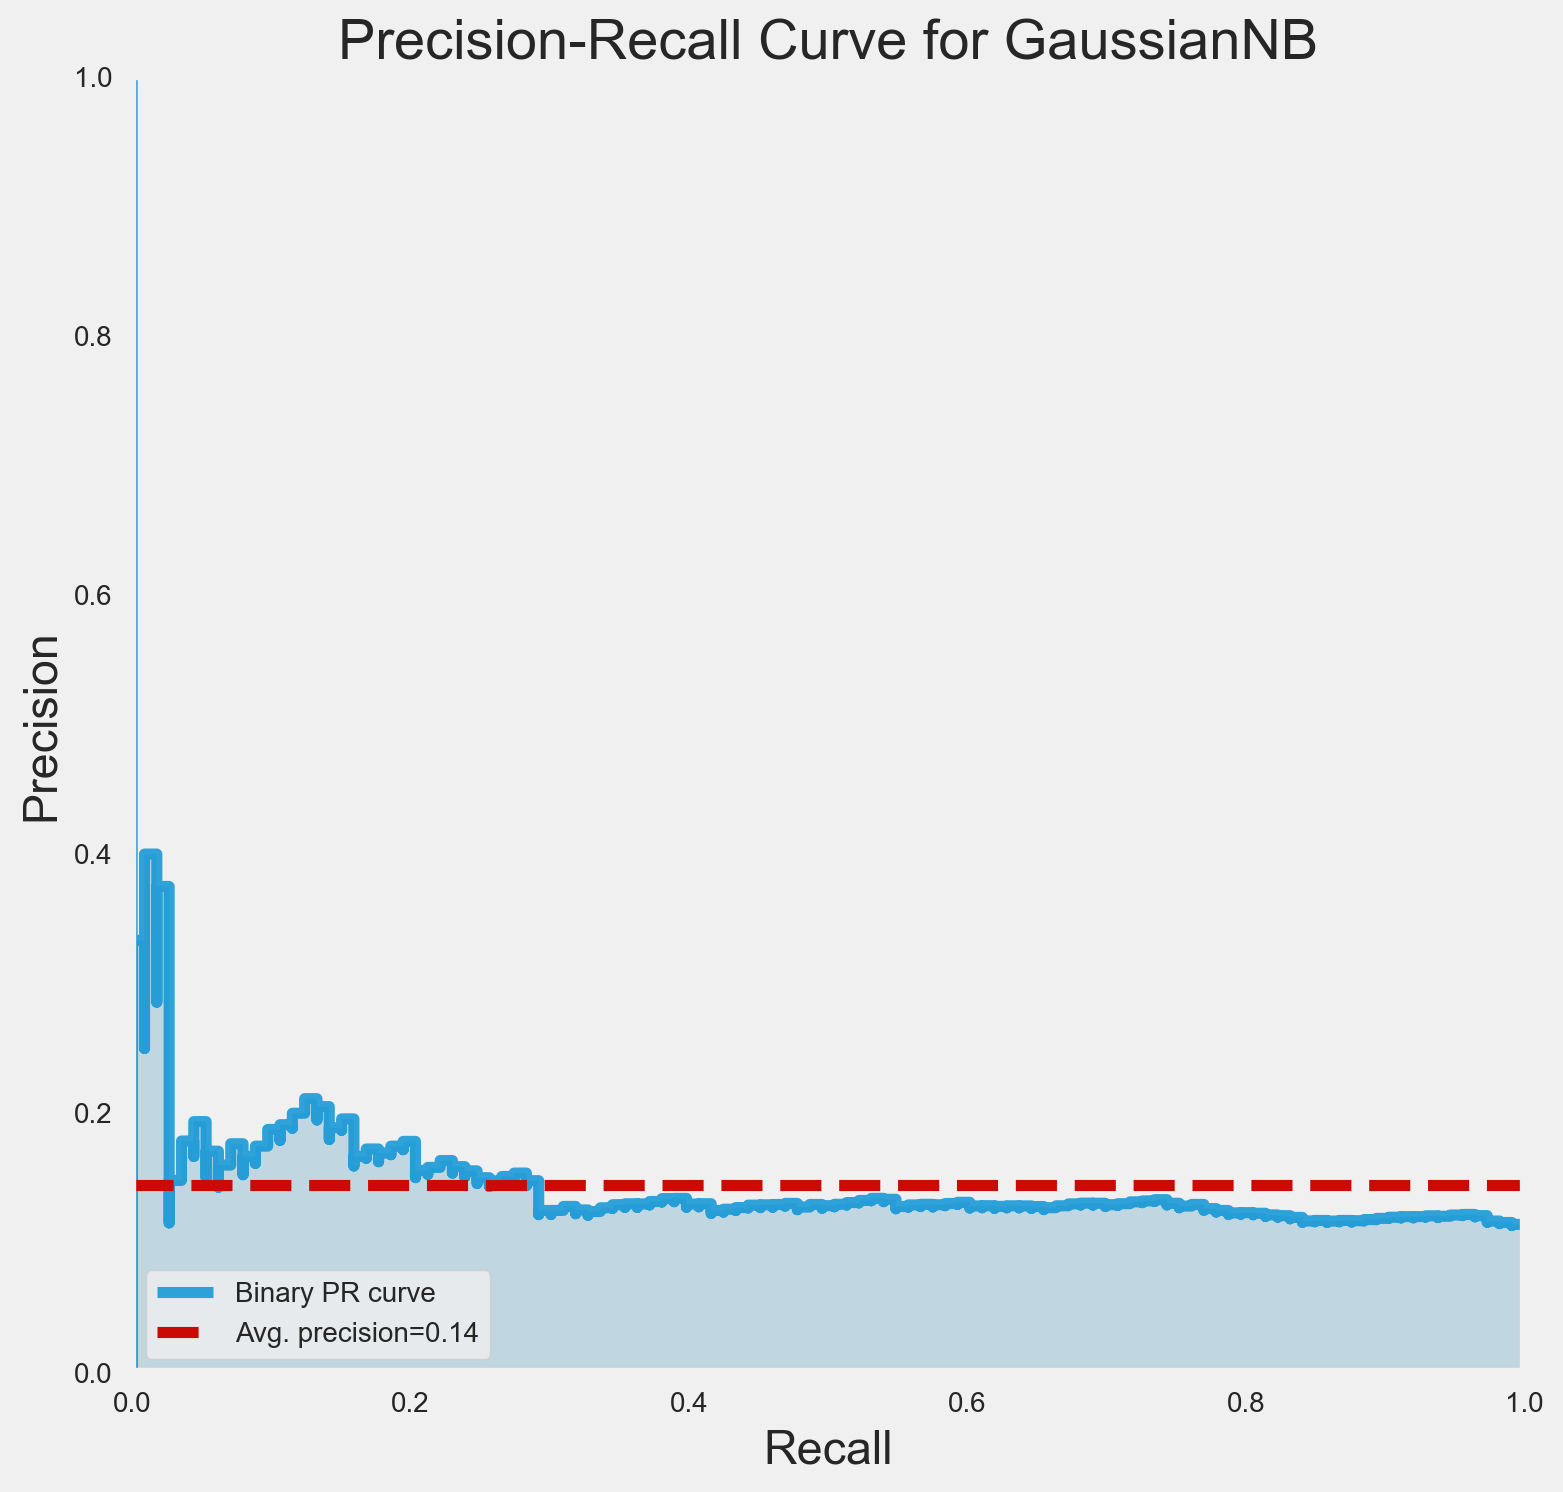

In [90]:
# Create a precision-recall curve
fig, ax = plt.subplots(figsize=(8, 8))
viz = PrecisionRecallCurve(GaussianNB())
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof();

#### Note

Finally for the naive bayes model, we are seeing an AUC of 0.56, which is comparable to the AUC of the logistic regression and KNN model. The average precision is also comparable to that of the logistic regression and KNN model. Considering the extra effort spent in upsampling the minority class for little to no improvement, I am of the opinion that either we should stick to the imbalanced dataset and try to make predictions (which is pointless since we won't be able to predict any of the positive labels) or look for features that actually have predictive value on handedness before building a model using those features.